In [2]:
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt

%matplotlib inline

Importing plotly failed. Interactive plots will not work.


In [3]:
# Read in average monthly temperature by state data
monthly_temps_path = 'Resources/average_monthly_temperature_by_state_1950-2022.csv'
monthly_temps_df = pd.read_csv(monthly_temps_path,
                               index_col='year')

In [4]:
# The Adidas dataset only has the two years 2020 & 2021, Clean for the relevant years
monthly_temps_df = monthly_temps_df.loc['2020':'2021']

monthly_temps_df = monthly_temps_df.rename_axis('Year')

# Clean columns
monthly_temps_df.drop(['Unnamed: 0', 'monthly_mean_from_1901_to_2000', 'centroid_lon', 'centroid_lat'], axis=1, inplace=True)

monthly_temps_df = monthly_temps_df.rename(
    columns={
        'month': 'Month',
        'state': 'State',
        'average_temp': 'Average Temp'
    }
)

In [5]:
monthly_temps_df.head()

,Month,State,Average Temp
Year,,,
2020,1,Alabama,50.4
2020,1,Arizona,43.0
2020,1,Arkansas,44.8
2020,1,California,44.8
2020,1,Colorado,27.8


In [6]:
# Resetting index to prep 'Year' for datetime type conversion
monthly_temps_df = monthly_temps_df.reset_index()

In [7]:
# Merging Year and Month columns as a datetime dtype
monthly_temps_df['Date'] = pd.to_datetime(monthly_temps_df['Year'].astype(str) + '-' + monthly_temps_df['Month'].astype(str).str.zfill(2))

# Dropping the irrelevent 'Days' as they all show as xx-xx-01
monthly_temps_df['Date'] = monthly_temps_df['Date'].dt.to_period('M')

# Setting index to the new datetime 'Date' column
monthly_temps_df = monthly_temps_df.set_index('Date')

# Dropping the now irrelevant duplicate columns
monthly_temps_df.drop(['Year', 'Month'], axis=1, inplace=True)


In [8]:
# Check the dtype conversion is correct
monthly_temps_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1152 entries, 2020-01 to 2021-12
Freq: M
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   State         1152 non-null   object 
 1   Average Temp  1152 non-null   float64
dtypes: float64(1), object(1)
memory usage: 27.0+ KB


In [9]:
# Check the formatting is correct
display(monthly_temps_df.head(10))
display(monthly_temps_df.tail(10))

,State,Average Temp
Date,,
2020-01,Alabama,50.4
2020-01,Arizona,43.0
2020-01,Arkansas,44.8
2020-01,California,44.8
2020-01,Colorado,27.8
2020-01,Connecticut,32.4
2020-01,Delaware,40.1
2020-01,Florida,62.8
2020-01,Georgia,51.8


,State,Average Temp
Date,,
2021-12,South Dakota,31.4
2021-12,Tennessee,48.0
2021-12,Texas,58.2
2021-12,Utah,36.8
2021-12,Vermont,31.2
2021-12,Virginia,45.2
2021-12,Washington,34.7
2021-12,West Virginia,41.8
2021-12,Wisconsin,29.3


In [10]:
# Groupby State, Year, and Month to sort
monthly_temps_by_state = monthly_temps_df.groupby(['State', monthly_temps_df.index.year, monthly_temps_df.index.month])['Average Temp'].sum()

display(monthly_temps_by_state.head(10))
display(monthly_temps_by_state.tail(10))

State    Date  Date
Alabama  2020  1       50.4
               2       50.2
               3       57.2
               4       62.8
               5       65.4
               6       72.9
               7       78.9
               8       80.6
               9       77.2
               10      70.6
Name: Average Temp, dtype: float64

State    Date  Date
Wyoming  2021  3       24.8
               4       35.0
               5       43.4
               6       56.8
               7       67.4
               8       67.1
               9       61.1
               10      51.0
               11      40.2
               12      31.3
Name: Average Temp, dtype: float64

In [11]:
# Rename the Indexes
monthly_temps_by_state.index.names = ['State', 'Year', 'Month']

monthly_temps_by_state.head()

State    Year  Month
Alabama  2020  1        50.4
               2        50.2
               3        57.2
               4        62.8
               5        65.4
Name: Average Temp, dtype: float64

In [12]:
# Save Cleaned temperature data csv
#monthly_temps_by_state.to_csv('Resources/avg_temps_cleaned.csv')


In [13]:
# Read in the Adidas xlsx
adidas_path = 'Resources/Round 4 Year_Adidas_Sales_Data_Monthly_Category_Summary.csv'
adidas_df = pd.read_csv(adidas_path,
                          index_col='Invoice Date',
                          parse_dates=True,
                          date_format='dateutil')


In [14]:
# Check it
adidas_df.head()

,Year,Month_Number,Month_Name,Region,State,City,Category,Subcategory,Product,Price per Unit,Units Sold,Total Sales,Profit per Unit,Operating Margin,Total Operating Profit,Year-Month
Invoice Date,,,,,,,,,,,,,,,,
2020-01-01,2020,1,Jan,Northeast,New York,New York,Street Footwear,Men's,Men's Street Footwear,50.0,1200,60000,25.00,0.50,30000.0,2020-01
2020-01-02,2020,1,Jan,Northeast,New York,New York,Athletic Footwear,Men's,Men's Athletic Footwear,50.0,1000,50000,15.00,0.30,15000.0,2020-01
2020-01-03,2020,1,Jan,Northeast,New York,New York,Street Footwear,Women's,Women's Street Footwear,40.0,1000,40000,14.00,0.35,14000.0,2020-01
2020-01-04,2020,1,Jan,Northeast,New York,New York,Athletic Footwear,Women's,Women's Athletic Footwear,45.0,850,38250,15.75,0.35,13387.5,2020-01
2020-01-05,2020,1,Jan,Northeast,New York,New York,Apparel,Men's,Men's Apparel,60.0,900,54000,18.00,0.30,16200.0,2020-01


In [15]:
monthly_temps_by_state.head()

State    Year  Month
Alabama  2020  1        50.4
               2        50.2
               3        57.2
               4        62.8
               5        65.4
Name: Average Temp, dtype: float64

In [16]:
adidas_df.columns

Index(['Year', 'Month_Number', 'Month_Name', 'Region', 'State', 'City',
       'Category', 'Subcategory', 'Product', 'Price per Unit', 'Units Sold',
       'Total Sales', 'Profit per Unit', 'Operating Margin',
       'Total Operating Profit', 'Year-Month'],
      dtype='object')

In [17]:
# Clean for relevent data to include Region, State, Product, Price per Unit, Units Sold, and Total Sales

adidas_df.drop(['Month_Name', 'City', 'Product', 'Price per Unit', 'Profit per Unit', 'Operating Margin', 'Total Operating Profit', 'Year-Month'], axis=1, inplace=True)
adidas_df = adidas_df.rename(
    columns={
        'Month_Number': 'Month',
        'Category': 'Product',
        'Subcategory': 'Gender'
    }
)

# Drop NaNs
adidas_df.dropna(inplace=True)

adidas_df.head()

,Year,Month,Region,State,Product,Gender,Units Sold,Total Sales
Invoice Date,,,,,,,,
2020-01-01,2020,1,Northeast,New York,Street Footwear,Men's,1200,60000
2020-01-02,2020,1,Northeast,New York,Athletic Footwear,Men's,1000,50000
2020-01-03,2020,1,Northeast,New York,Street Footwear,Women's,1000,40000
2020-01-04,2020,1,Northeast,New York,Athletic Footwear,Women's,850,38250
2020-01-05,2020,1,Northeast,New York,Apparel,Men's,900,54000


In [18]:
#groupby relevent data to get sum of units sold and total sales
adidas_df = adidas_df.reset_index()

adidas_df.drop(['Invoice Date'],axis=1, inplace=True)

adidas_df = adidas_df.groupby(['State', 'Year', 'Region', 'Month', 'Gender', 'Product'])[['Units Sold', 'Total Sales']].sum()
adidas_df = pd.DataFrame(adidas_df)
display(adidas_df.head())
display(adidas_df.tail())

Units Sold  Total Sales
State   Year Region Month Gender  Product                                   
Alabama 2021 South  8     Men's   Apparel                  2430        91281
                                  Athletic Footwear        4146       111112
                                  Street Footwear          5334       129994
                          Women's Apparel                  4189       137378
                                  Athletic Footwear        2561        75010

Units Sold  Total Sales
State   Year Region Month Gender  Product                                   
Wyoming 2021 West   12    Men's   Athletic Footwear         768        34392
                                  Street Footwear          1024        55648
                          Women's Apparel                   774        45744
                                  Athletic Footwear         635        28440
                                  Street Footwear           715        32010

In [19]:
# checking dtypes
adidas_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3030 entries, ('Alabama', np.int64(2021), 'South', np.int64(8), "Men's", 'Apparel') to ('Wyoming', np.int64(2021), 'West', np.int64(12), "Women's", 'Street Footwear')
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Units Sold   3030 non-null   int64
 1   Total Sales  3030 non-null   int64
dtypes: int64(2)
memory usage: 65.9+ KB


In [20]:
#save cleaned df for concatenation with temps df
#adidas_df.to_csv('Resources/aggregated_adidas_data.csv')

In [21]:
#read in cleaned and concatenated data
adidas_concat_path = 'Resources/Concatenated Adidas Sales Data With Temperature.csv'

adidas_concat = pd.read_csv(adidas_concat_path).dropna()

adidas_concat.head()

,State,Year,Month,Region,Gender,Product,Units Sold,Total Sales,Average Temp
0,Alabama,2021,8,South,Men's,Apparel,2430,91281,79.7
1,Alabama,2021,8,South,Men's,Athletic Footwear,4146,111112,79.7
2,Alabama,2021,8,South,Men's,Street Footwear,5334,129994,79.7
3,Alabama,2021,8,South,Women's,Apparel,4189,137378,79.7
4,Alabama,2021,8,South,Women's,Athletic Footwear,2561,75010,79.7


In [22]:
adidas_concat = adidas_concat[adidas_concat['Year'] == 2021]
adidas_concat.head()

,State,Year,Month,Region,Gender,Product,Units Sold,Total Sales,Average Temp
0,Alabama,2021,8,South,Men's,Apparel,2430,91281,79.7
1,Alabama,2021,8,South,Men's,Athletic Footwear,4146,111112,79.7
2,Alabama,2021,8,South,Men's,Street Footwear,5334,129994,79.7
3,Alabama,2021,8,South,Women's,Apparel,4189,137378,79.7
4,Alabama,2021,8,South,Women's,Athletic Footwear,2561,75010,79.7


In [36]:
adidas_concat["Average Temp"] = adidas_concat["Average Temp"].apply(int)

In [37]:
adidas_concat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2706 entries, 0 to 3029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   State         2706 non-null   object
 1   Year          2706 non-null   int64 
 2   Month         2706 non-null   int64 
 3   Region        2706 non-null   object
 4   Gender        2706 non-null   object
 5   Product       2706 non-null   object
 6   Units Sold    2706 non-null   int64 
 7   Total Sales   2706 non-null   int64 
 8   Average Temp  2706 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 211.4+ KB


In [38]:
#slice to filter for Apparel Footwear sales and temp

adidas_apparel = adidas_concat[adidas_concat['Product'].str.contains('Apparel')]
display(adidas_apparel.head())
display(adidas_apparel.tail())
adidas_apparel['Product'].unique()

,State,Year,Month,Region,Gender,Product,Units Sold,Total Sales,Average Temp
0,Alabama,2021,8,South,Men's,Apparel,2430,91281,79
3,Alabama,2021,8,South,Women's,Apparel,4189,137378,79
6,Alabama,2021,9,South,Men's,Apparel,3370,149180,76
9,Alabama,2021,9,South,Women's,Apparel,5460,265670,76
12,Alabama,2021,10,South,Men's,Apparel,1485,76700,70


,State,Year,Month,Region,Gender,Product,Units Sold,Total Sales,Average Temp
3015,Wyoming,2021,10,West,Women's,Apparel,750,44250,51
3018,Wyoming,2021,11,West,Men's,Apparel,618,33418,40
3021,Wyoming,2021,11,West,Women's,Apparel,736,43355,40
3024,Wyoming,2021,12,West,Men's,Apparel,645,35330,31
3027,Wyoming,2021,12,West,Women's,Apparel,774,45744,31


array(['Apparel'], dtype=object)

In [39]:
#groupby visualization for testing
adidas_apparel= adidas_apparel.groupby(['State', 'Region', 'Year', 'Month', 'Gender', 'Product', 'Average Temp'])[['Units Sold', 'Total Sales']].sum()
adidas_apparel = pd.DataFrame(adidas_apparel)
display(adidas_apparel.head(10))
display(adidas_apparel.tail(10))

Units Sold  \
State   Region Year Month Gender  Product Average Temp               
Alabama South  2021 8     Men's   Apparel 79                  2430   
                          Women's Apparel 79                  4189   
                    9     Men's   Apparel 76                  3370   
                          Women's Apparel 76                  5460   
                    10    Men's   Apparel 70                  1485   
                          Women's Apparel 70                  2179   
Arizona West   2021 1     Men's   Apparel 42                   449   
                          Women's Apparel 42                   769   
                    2     Men's   Apparel 44                   245   
                          Women's Apparel 44                   554   

                                                        Total Sales  
State   Region Year Month Gender  Product Average Temp               
Alabama South  2021 8     Men's   Apparel 79                  91281  
                          Women's Apparel 79                 137378  
                    9     Men's   Apparel 76                 149180  
                          Women's Apparel 76                 265670  
                    10    Men's   Apparel 70                  76700  
                          Women's Apparel 70                 135392  
Arizona West   2021 1     Men's   Apparel 42                  20452  
                          Women's Apparel 42                  32727  
                    2     Men's   Apparel 44                  10434  
                          Women's Apparel 44                  20940

Units Sold  \
State   Region Year Month Gender  Product Average Temp               
Wyoming West   2021 8     Men's   Apparel 67                   640   
                          Women's Apparel 67                   871   
                    9     Men's   Apparel 61                   625   
                          Women's Apparel 61                   774   
                    10    Men's   Apparel 51                   603   
                          Women's Apparel 51                   750   
                    11    Men's   Apparel 40                   618   
                          Women's Apparel 40                   736   
                    12    Men's   Apparel 31                   645   
                          Women's Apparel 31                   774   

                                                        Total Sales  
State   Region Year Month Gender  Product Average Temp               
Wyoming West   2021 8     Men's   Apparel 67                  31580  
                          Women's Apparel 67                  47317  
                    9     Men's   Apparel 61                  31000  
                          Women's Apparel 61                  42048  
                    10    Men's   Apparel 51                  33037  
                          Women's Apparel 51                  44250  
                    11    Men's   Apparel 40                  33418  
                          Women's Apparel 40                  43355  
                    12    Men's   Apparel 31                  35330  
                          Women's Apparel 31                  45744

In [40]:
adidas_apparel = adidas_apparel.reset_index()

adidas_apparel = adidas_apparel.set_index(['State', 'Region', 'Year', 'Month'])

adidas_apparel.head()

Gender  Product  Average Temp  Units Sold  \
State   Region Year Month                                               
Alabama South  2021 8        Men's  Apparel            79        2430   
                    8      Women's  Apparel            79        4189   
                    9        Men's  Apparel            76        3370   
                    9      Women's  Apparel            76        5460   
                    10       Men's  Apparel            70        1485   

                           Total Sales  
State   Region Year Month               
Alabama South  2021 8            91281  
                    8           137378  
                    9           149180  
                    9           265670  
                    10           76700

In [41]:
adidas_mens_apparel = adidas_apparel[adidas_apparel['Gender'].str.match("Men's")]
adidas_mens_apparel.head()

Gender  Product  Average Temp  Units Sold  \
State   Region Year Month                                             
Alabama South  2021 8      Men's  Apparel            79        2430   
                    9      Men's  Apparel            76        3370   
                    10     Men's  Apparel            70        1485   
Arizona West   2021 1      Men's  Apparel            42         449   
                    2      Men's  Apparel            44         245   

                           Total Sales  
State   Region Year Month               
Alabama South  2021 8            91281  
                    9           149180  
                    10           76700  
Arizona West   2021 1            20452  
                    2            10434

In [42]:
#regrouping to drop and rename rows
adidas_mens_apparel = adidas_mens_apparel.groupby(['State', 'Region', 'Year', 'Month', 'Average Temp'])[['Units Sold', 'Total Sales']].sum()
adidas_mens_apparel= adidas_mens_apparel.rename(
    columns={
        'Units Sold': '(M)Units Sold',
        'Total Sales': "Men's Apparel Sales"})
adidas_mens_apparel.head()

(M)Units Sold  Men's Apparel Sales
State   Region Year Month Average Temp                                    
Alabama South  2021 8     79                     2430                91281
                    9     76                     3370               149180
                    10    70                     1485                76700
Arizona West   2021 1     42                      449                20452
                    2     44                      245                10434

In [43]:

adidas_womens_apparel = adidas_apparel[adidas_apparel['Gender'].str.match("Women's")]
adidas_womens_apparel.head()

Gender  Product  Average Temp  Units Sold  \
State   Region Year Month                                               
Alabama South  2021 8      Women's  Apparel            79        4189   
                    9      Women's  Apparel            76        5460   
                    10     Women's  Apparel            70        2179   
Arizona West   2021 1      Women's  Apparel            42         769   
                    2      Women's  Apparel            44         554   

                           Total Sales  
State   Region Year Month               
Alabama South  2021 8           137378  
                    9           265670  
                    10          135392  
Arizona West   2021 1            32727  
                    2            20940

In [44]:
adidas_womens_apparel = adidas_womens_apparel.groupby(['State', 'Region', 'Year', 'Month', 'Average Temp'])[['Units Sold', 'Total Sales']].sum()
adidas_womens_apparel= adidas_womens_apparel.rename(
    columns={
        'Units Sold': '(W)Units Sold',
        'Total Sales': "Women's Apparel Sales"})
adidas_womens_apparel.head()

(W)Units Sold  Women's Apparel Sales
State   Region Year Month Average Temp                                      
Alabama South  2021 8     79                     4189                 137378
                    9     76                     5460                 265670
                    10    70                     2179                 135392
Arizona West   2021 1     42                      769                  32727
                    2     44                      554                  20940

In [45]:
adidas_apparel = pd.concat([adidas_mens_apparel, adidas_womens_apparel], axis=1)
display(adidas_apparel.head(10))
display(adidas_apparel.tail(10))

(M)Units Sold  Men's Apparel Sales  \
State   Region Year Month Average Temp                                       
Alabama South  2021 8     79                   2430.0              91281.0   
                    9     76                   3370.0             149180.0   
                    10    70                   1485.0              76700.0   
Arizona West   2021 1     42                    449.0              20452.0   
                    2     44                    245.0              10434.0   
                    3     48                    195.0              10148.0   
                    4     55                    236.0              12221.0   
                    5     64                    320.0              16376.0   
                    6     74                    365.0              18939.0   
                    7     81                    698.0              35831.0   

                                        (W)Units Sold  Women's Apparel Sales  
State   Region Year Month Average Temp                                        
Alabama South  2021 8     79                     4189                 137378  
                    9     76                     5460                 265670  
                    10    70                     2179                 135392  
Arizona West   2021 1     42                      769                  32727  
                    2     44                      554                  20940  
                    3     48                      520                  24345  
                    4     55                      530                  34487  
                    5     64                      597                  39094  
                    6     74                      814                  53057  
                    7     81                      693                  44661

(M)Units Sold  Men's Apparel Sales  \
State   Region    Year Month Average Temp                                       
Wyoming West      2021 4     35                    531.0              26232.0   
                       5     43                    608.0              29735.0   
                       6     56                    635.0              31615.0   
                       7     67                    662.0              32826.0   
                       8     67                    640.0              31580.0   
                       9     61                    625.0              31000.0   
                       10    51                    603.0              33037.0   
                       11    40                    618.0              33418.0   
                       12    31                    645.0              35330.0   
Maine   Northeast 2021 9     63                      NaN                  NaN   

                                           (W)Units Sold  \
State   Region    Year Month Average Temp                  
Wyoming West      2021 4     35                      699   
                       5     43                      756   
                       6     56                      813   
                       7     67                      896   
                       8     67                      871   
                       9     61                      774   
                       10    51                      750   
                       11    40                      736   
                       12    31                      774   
Maine   Northeast 2021 9     63                      284   

                                           Women's Apparel Sales  
State   Region    Year Month Average Temp                         
Wyoming West      2021 4     35                            27364  
                       5     43                            41112  
                       6     56                            43900  
                       7     67                            48496  
                       8     67                            47317  
                       9     61                            42048  
                       10    51                            44250  
                       11    40                            43355  
                       12    31                            45744  
Maine   Northeast 2021 9     63                            16863

In [46]:
adidas_apparel = adidas_apparel[['(M)Units Sold', "Men's Apparel Sales", '(W)Units Sold', "Women's Apparel Sales"]]
display(adidas_apparel.head(10))
display(adidas_apparel.tail(10))

(M)Units Sold  Men's Apparel Sales  \
State   Region Year Month Average Temp                                       
Alabama South  2021 8     79                   2430.0              91281.0   
                    9     76                   3370.0             149180.0   
                    10    70                   1485.0              76700.0   
Arizona West   2021 1     42                    449.0              20452.0   
                    2     44                    245.0              10434.0   
                    3     48                    195.0              10148.0   
                    4     55                    236.0              12221.0   
                    5     64                    320.0              16376.0   
                    6     74                    365.0              18939.0   
                    7     81                    698.0              35831.0   

                                        (W)Units Sold  Women's Apparel Sales  
State   Region Year Month Average Temp                                        
Alabama South  2021 8     79                     4189                 137378  
                    9     76                     5460                 265670  
                    10    70                     2179                 135392  
Arizona West   2021 1     42                      769                  32727  
                    2     44                      554                  20940  
                    3     48                      520                  24345  
                    4     55                      530                  34487  
                    5     64                      597                  39094  
                    6     74                      814                  53057  
                    7     81                      693                  44661

(M)Units Sold  Men's Apparel Sales  \
State   Region    Year Month Average Temp                                       
Wyoming West      2021 4     35                    531.0              26232.0   
                       5     43                    608.0              29735.0   
                       6     56                    635.0              31615.0   
                       7     67                    662.0              32826.0   
                       8     67                    640.0              31580.0   
                       9     61                    625.0              31000.0   
                       10    51                    603.0              33037.0   
                       11    40                    618.0              33418.0   
                       12    31                    645.0              35330.0   
Maine   Northeast 2021 9     63                      NaN                  NaN   

                                           (W)Units Sold  \
State   Region    Year Month Average Temp                  
Wyoming West      2021 4     35                      699   
                       5     43                      756   
                       6     56                      813   
                       7     67                      896   
                       8     67                      871   
                       9     61                      774   
                       10    51                      750   
                       11    40                      736   
                       12    31                      774   
Maine   Northeast 2021 9     63                      284   

                                           Women's Apparel Sales  
State   Region    Year Month Average Temp                         
Wyoming West      2021 4     35                            27364  
                       5     43                            41112  
                       6     56                            43900  
                       7     67                            48496  
                       8     67                            47317  
                       9     61                            42048  
                       10    51                            44250  
                       11    40                            43355  
                       12    31                            45744  
Maine   Northeast 2021 9     63                            16863

In [47]:
#checking for nulls and dtypes
adidas_apparel.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 450 entries, ('Alabama', 'South', np.int64(2021), np.int64(8), np.int64(79)) to ('Maine', 'Northeast', np.int64(2021), np.int64(9), np.int64(63))
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (M)Units Sold          449 non-null    float64
 1   Men's Apparel Sales    449 non-null    float64
 2   (W)Units Sold          450 non-null    int64  
 3   Women's Apparel Sales  450 non-null    int64  
dtypes: float64(2), int64(2)
memory usage: 17.5+ KB


In [48]:
adidas_apparel.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 450 entries, ('Alabama', 'South', np.int64(2021), np.int64(8), np.int64(79)) to ('Maine', 'Northeast', np.int64(2021), np.int64(9), np.int64(63))
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (M)Units Sold          449 non-null    float64
 1   Men's Apparel Sales    449 non-null    float64
 2   (W)Units Sold          450 non-null    int64  
 3   Women's Apparel Sales  450 non-null    int64  
dtypes: float64(2), int64(2)
memory usage: 17.5+ KB


In [49]:
adidas_apparel.index

MultiIndex([('Alabama',     'South', 2021,  8, 79),
            ('Alabama',     'South', 2021,  9, 76),
            ('Alabama',     'South', 2021, 10, 70),
            ('Arizona',      'West', 2021,  1, 42),
            ('Arizona',      'West', 2021,  2, 44),
            ('Arizona',      'West', 2021,  3, 48),
            ('Arizona',      'West', 2021,  4, 55),
            ('Arizona',      'West', 2021,  5, 64),
            ('Arizona',      'West', 2021,  6, 74),
            ('Arizona',      'West', 2021,  7, 81),
            ...
            ('Wyoming',      'West', 2021,  4, 35),
            ('Wyoming',      'West', 2021,  5, 43),
            ('Wyoming',      'West', 2021,  6, 56),
            ('Wyoming',      'West', 2021,  7, 67),
            ('Wyoming',      'West', 2021,  8, 67),
            ('Wyoming',      'West', 2021,  9, 61),
            ('Wyoming',      'West', 2021, 10, 51),
            ('Wyoming',      'West', 2021, 11, 40),
            ('Wyoming',      'West', 2021, 12, 3

In [52]:
adidas_apparel_by_regions = adidas_apparel.reset_index()
adidas_apparel_by_regions = adidas_apparel_by_regions.set_index(['Region', 'Year', 'Month'])
adidas_apparel_by_regions.drop(['State'], axis=1, inplace=True)
adidas_apparel_by_regions.head()

Average Temp  (M)Units Sold  Men's Apparel Sales  \
Region Year Month                                                     
South  2021 8                79         2430.0              91281.0   
            9                76         3370.0             149180.0   
            10               70         1485.0              76700.0   
West   2021 1                42          449.0              20452.0   
            2                44          245.0              10434.0   

                   (W)Units Sold  Women's Apparel Sales  
Region Year Month                                        
South  2021 8               4189                 137378  
            9               5460                 265670  
            10              2179                 135392  
West   2021 1                769                  32727  
            2                554                  20940

In [53]:
adidas_apparel_by_regions = adidas_apparel_by_regions.reset_index()
adidas_apparel_by_regions.head()

,Region,Year,Month,Average Temp,(M)Units Sold,Men's Apparel Sales,(W)Units Sold,Women's Apparel Sales
0,South,2021,8,79,2430.0,91281.0,4189,137378
1,South,2021,9,76,3370.0,149180.0,5460,265670
2,South,2021,10,70,1485.0,76700.0,2179,135392
3,West,2021,1,42,449.0,20452.0,769,32727
4,West,2021,2,44,245.0,10434.0,554,20940


In [54]:
adidas_apparel_by_regions['Year'].unique

<bound method Series.unique of 0      2021
1      2021
2      2021
3      2021
4      2021
       ... 
445    2021
446    2021
447    2021
448    2021
449    2021
Name: Year, Length: 450, dtype: int64>

In [56]:
#resetting index to drop "Year"
adidas_apparel_by_regions = adidas_apparel_by_regions.reset_index()
adidas_apparel_by_regions.head()

,index,Region,Year,Month,Average Temp,(M)Units Sold,Men's Apparel Sales,(W)Units Sold,Women's Apparel Sales
0,0,South,2021,8,79,2430.0,91281.0,4189,137378
1,1,South,2021,9,76,3370.0,149180.0,5460,265670
2,2,South,2021,10,70,1485.0,76700.0,2179,135392
3,3,West,2021,1,42,449.0,20452.0,769,32727
4,4,West,2021,2,44,245.0,10434.0,554,20940


In [57]:
#making sure we're only using data from 2021
adidas_apparel_by_regions['Year'].unique

<bound method Series.unique of 0      2021
1      2021
2      2021
3      2021
4      2021
       ... 
445    2021
446    2021
447    2021
448    2021
449    2021
Name: Year, Length: 450, dtype: int64>

In [58]:
adidas_apparel_by_regions.drop('Year', axis=1, inplace=True)
adidas_apparel_by_regions = adidas_apparel_by_regions.sort_values('Average Temp', ascending=True)

adidas_apparel_by_regions = adidas_apparel_by_regions.set_index('Region')
display(adidas_apparel_by_regions.head())
display(adidas_apparel_by_regions.tail())

,index,Month,Average Temp,(M)Units Sold,Men's Apparel Sales,(W)Units Sold,Women's Apparel Sales
Region,,,,,,,
Midwest,285,2,13,226.0,10016.0,344,8461
Midwest,426,2,15,188.0,7444.0,315,4659
Midwest,108,2,18,188.0,7444.0,318,4701
Northeast,390,2,19,356.0,18225.0,517,22025
Midwest,360,2,19,221.0,10957.0,355,12185


,index,Month,Average Temp,(M)Units Sold,Men's Apparel Sales,(W)Units Sold,Women's Apparel Sales
Region,,,,,,,
West,9,7,81,698.0,35831.0,693,44661
Southeast,64,9,81,443.0,29062.0,474,24482
South,374,8,81,1527.0,56546.0,2368,77349
South,150,8,82,765.0,46850.0,492,31362
Southeast,63,8,82,784.0,59040.0,483,38307


In [59]:
adidas_mens_apparel_temps = adidas_apparel_by_regions[['Month', 'Average Temp', '(M)Units Sold', 'Men\'s Apparel Sales']]
adidas_mens_apparel_temps.head()

,Month,Average Temp,(M)Units Sold,Men's Apparel Sales
Region,,,,
Midwest,2,13,226.0,10016.0
Midwest,2,15,188.0,7444.0
Midwest,2,18,188.0,7444.0
Northeast,2,19,356.0,18225.0
Midwest,2,19,221.0,10957.0


In [61]:
adidas_womens_apparel_temps = adidas_apparel_by_regions[['Month', 'Average Temp', '(W)Units Sold', 'Women\'s Apparel Sales']]
adidas_womens_apparel_temps.head()

,Month,Average Temp,(W)Units Sold,Women's Apparel Sales
Region,,,,
Midwest,2,13,344,8461
Midwest,2,15,315,4659
Midwest,2,18,318,4701
Northeast,2,19,517,22025
Midwest,2,19,355,12185


In [63]:
#sorting both by months
adidas_mens_apparel_temps = adidas_mens_apparel_temps.sort_values('Month', ascending=True)
adidas_womens_apparel_temps = adidas_womens_apparel_temps.sort_values('Month', ascending=True)

In [64]:
#adding mens and womens sales for a total sales of Apparel Sales by region
adidas_apparel_by_regions['Total Sales'] = adidas_apparel_by_regions['Men\'s Apparel Sales'] + adidas_apparel_by_regions['Women\'s Apparel Sales']

#creating a total Apparel Sales by region per month dataframe for visual comparisons
adidas_apparel_by_month = adidas_apparel_by_regions[['Month', 'Total Sales']]

#dropping irrelevent columns for temperature vs sales analysis
adidas_apparel_by_regions.drop(['Men\'s Apparel Sales', 'Women\'s Apparel Sales', '(M)Units Sold', '(W)Units Sold', 'Month'], axis=1, inplace=True)
adidas_apparel_by_regions = adidas_apparel_by_regions.sort_values('Average Temp')
display(adidas_apparel_by_regions.head())
display(adidas_apparel_by_month.head())

,index,Average Temp,Total Sales
Region,,,
Midwest,285,13,18477.0
Midwest,426,15,12103.0
Midwest,108,18,12145.0
Northeast,390,19,40250.0
Midwest,360,19,23142.0


,Month,Total Sales
Region,,
Midwest,2,18477.0
Midwest,2,12103.0
Midwest,2,12145.0
Northeast,2,40250.0
Midwest,2,23142.0


In [65]:
adidas_apparel_by_regions.index.unique()

Index(['Midwest', 'Northeast', 'West', 'Southeast', 'South'], dtype='object', name='Region')

In [66]:
'''Creating DataFrames for each Region \n
(Midwest, Northeast, West, Southeast, South)\n
to plot and analyze Average Temp vs Total Sales for each Region'''

#grab Average Temp and Total Sales for the Midwest
adidas_apparel_mw = adidas_apparel_by_regions[['Average Temp', 'Total Sales']].loc['Midwest']
adidas_apparel_mw = adidas_apparel_mw.reset_index()
adidas_apparel_mw.drop(['Region'], axis=1, inplace=True)
adidas_apparel_mw = adidas_apparel_mw.set_index('Average Temp')
adidas_apparel_mw = adidas_apparel_mw.rename(
    columns={
        'Total Sales': '(Midwest) Total Sales'
    }
)
adidas_apparel_mw.head()

,(Midwest) Total Sales
Average Temp,
13,18477.0
15,12103.0
18,12145.0
19,23142.0
20,282787.0


In [67]:
#grab Average Temp and Total Sales for the Midwest
adidas_apparel_mw = adidas_apparel_by_regions[['Average Temp', 'Total Sales']].loc['Midwest']
adidas_apparel_mw = adidas_apparel_mw.reset_index()
adidas_apparel_mw.drop(['Region'], axis=1, inplace=True)
adidas_apparel_mw = adidas_apparel_mw.set_index('Average Temp')
adidas_apparel_mw = adidas_apparel_mw.rename(
    columns={
        'Total Sales': '(Midwest) Total Sales'
    }
)
adidas_apparel_mw.head()

,(Midwest) Total Sales
Average Temp,
13,18477.0
15,12103.0
18,12145.0
19,23142.0
20,282787.0


In [68]:
adidas_apparel_ne = adidas_apparel_by_regions[['Average Temp', 'Total Sales']].loc['Northeast']
adidas_apparel_ne = adidas_apparel_ne.reset_index()
adidas_apparel_ne.drop(['Region'], axis=1, inplace=True)
adidas_apparel_ne = adidas_apparel_ne.set_index('Average Temp')
adidas_apparel_ne = adidas_apparel_ne.rename(
    columns={
        'Total Sales': '(Northeast) Total Sales'
    }
)
adidas_apparel_ne.head()

,(Northeast) Total Sales
Average Temp,
19,40250.0
21,52806.0
22,74844.0
23,44083.0
24,32477.0


In [69]:
adidas_apparel_w = adidas_apparel_by_regions[['Average Temp', 'Total Sales']].loc['West']
adidas_apparel_w = adidas_apparel_w.reset_index()
adidas_apparel_w.drop(['Region'], axis=1, inplace=True)
adidas_apparel_w = adidas_apparel_w.set_index('Average Temp')
adidas_apparel_w = adidas_apparel_w.rename(
    columns={
        'Total Sales': '(West) Total Sales'
    }
)
adidas_apparel_w.head()

,(West) Total Sales
Average Temp,
20,62427.0
24,56527.0
24,29048.0
26,39172.0
26,39927.0


In [70]:
adidas_apparel_se = adidas_apparel_by_regions[['Average Temp', 'Total Sales']].loc['Southeast']
adidas_apparel_se = adidas_apparel_se.reset_index()
adidas_apparel_se.drop(['Region'], axis=1, inplace=True)
adidas_apparel_se = adidas_apparel_se.set_index('Average Temp')
adidas_apparel_se = adidas_apparel_se.rename(
    columns={
        'Total Sales': '(Southeast) Total Sales'
    }
)
adidas_apparel_se.head()

,(Southeast) Total Sales
Average Temp,
34,27633.0
36,27640.0
36,41702.0
37,58325.0
41,61807.0


In [71]:
adidas_apparel_s = adidas_apparel_by_regions[['Average Temp', 'Total Sales']].loc['South']
adidas_apparel_s = adidas_apparel_s.reset_index()
adidas_apparel_s.drop(['Region'], axis=1, inplace=True)
adidas_apparel_s = adidas_apparel_s.set_index('Average Temp')
adidas_apparel_s = adidas_apparel_s.rename(
    columns={
        'Total Sales': '(South) Total Sales'
    }
)
adidas_apparel_s.head()

,(South) Total Sales
Average Temp,
35,23672.0
38,30265.0
40,26478.0
42,28288.0
42,19423.0


In [72]:
avg_temp_mw_apparel = adidas_mens_apparel_temps['Average Temp'].loc['Midwest']
mens_total_apparel_sales_mw = adidas_mens_apparel_temps['Men\'s Apparel Sales'].loc['Midwest']
mw_apparel_months = adidas_mens_apparel_temps['Month'].loc['Midwest']

womens_total_apparel_sales_mw = adidas_womens_apparel_temps['Women\'s Apparel Sales'].loc['Midwest']

In [73]:
avg_temp_ne_apparel = adidas_mens_apparel_temps['Average Temp'].loc['Northeast']
mens_total_apparel_sales_ne = adidas_mens_apparel_temps['Men\'s Apparel Sales'].loc['Northeast']
ne_apparel_months = adidas_mens_apparel_temps['Month'].loc['Northeast']

womens_total_apparel_sales_ne = adidas_womens_apparel_temps['Women\'s Apparel Sales'].loc['Northeast']

In [74]:
avg_temp_w_apparel = adidas_mens_apparel_temps['Average Temp'].loc['West']
mens_total_apparel_sales_w = adidas_mens_apparel_temps['Men\'s Apparel Sales'].loc['West']
w_apparel_months = adidas_mens_apparel_temps['Month'].loc['West']

womens_total_apparel_sales_w = adidas_womens_apparel_temps['Women\'s Apparel Sales'].loc['West']

In [75]:
avg_temp_se_apparel = adidas_mens_apparel_temps['Average Temp'].loc['Southeast']
mens_total_apparel_sales_se = adidas_mens_apparel_temps['Men\'s Apparel Sales'].loc['Southeast']
se_apparel_months = adidas_mens_apparel_temps['Month'].loc['Southeast']

womens_total_apparel_sales_se = adidas_womens_apparel_temps['Women\'s Apparel Sales'].loc['Southeast']

In [76]:
avg_temp_s_apparel = adidas_mens_apparel_temps['Average Temp'].loc['South']
mens_total_apparel_sales_s = adidas_mens_apparel_temps['Men\'s Apparel Sales'].loc['South']
s_apparel_months = adidas_mens_apparel_temps['Month'].loc['South']

womens_total_apparel_sales_s = adidas_womens_apparel_temps['Women\'s Apparel Sales'].loc['South']

In [245]:
'''Concatenating Midwest Months, Temp and Mens Total Sales for Midwest, Northeast, West, Southeast, and South. \n
Then Dropping Region and Month to clean down to average temp and Total Sales'''

#concat mw months, temp and total sales
mw_mens_merged = pd.concat([mw_months, avg_temp_mw, mens_total_sales_mw], axis=1)
mw_mens_merged = mw_mens_merged.sort_values('Average Temp', ascending=True)
mw_mens_merged.head(5)

,Month,Average Temp,Men's Athletic Footwear Sales
Region,,,
Midwest,2,13.4,5760
Midwest,2,15.4,8768
Midwest,2,18.2,5631
Midwest,2,19.6,7859
Midwest,2,20.2,183892


In [79]:
#check total sales for all products by Year and Month
adidas_df = adidas_df.reset_index()
adidas_monthly_sales = adidas_df.groupby(['Year', 'Month'])['Total Sales'].sum()

print(adidas_monthly_sales)

Year  Month
2020  1         2312742
      2         2140813
      3         2474199
      4         3193080
      5         2164764
      6         1084191
      7         2182388
      8         2641630
      9         2367686
      10        1428567
      11        1168049
      12        1079194
2021  1         7432010
      2         6123021
      3         5220756
      4         6498318
      5         8576901
      6         8718921
      7        10368006
      8         9651574
      9         8037879
      10        7110158
      11        7855364
      12       10336107
Name: Total Sales, dtype: int64


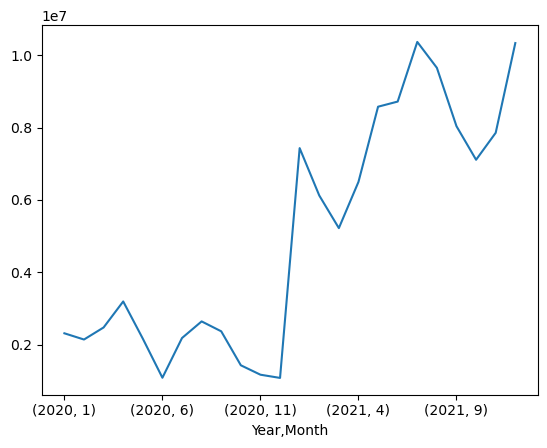

In [80]:
#plot total sales by year and month
adidas_monthly_sales.plot()
plt.show()

In [81]:
#slice for just 2021 sales
adidas_2021_sales = adidas_monthly_sales.iloc[12:]
adidas_2021_sales.index.names = ['Year', 'Month']
adidas_2021_sales = adidas_2021_sales.reset_index()
adidas_2021_sales = pd.DataFrame(adidas_2021_sales)
adidas_2021_sales.drop('Year', axis=1, inplace=True)
adidas_2021_sales = adidas_2021_sales.set_index('Month')
adidas_2021_sales = adidas_2021_sales.rename(
    columns={
        'Total Sales': '2021 Total Sales per Month'
    }
)
adidas_2021_sales.head(12)

,2021 Total Sales per Month
Month,
1,7432010
2,6123021
3,5220756
4,6498318
5,8576901
6,8718921
7,10368006
8,9651574
9,8037879


In [82]:
#sort total sales by region
adidas_monthly_sales_by_region = adidas_df.groupby(['Region', 'Year', 'Month'])['Total Sales'].sum()



print(adidas_monthly_sales_by_region)

Region   Year  Month
Midwest  2020  10        110887
               11        372082
               12        420938
         2021  1        1365832
               2        1514927
                         ...   
West     2021  8        2150828
               9        1523051
               10       1327708
               11       1746710
               12       2118455
Name: Total Sales, Length: 89, dtype: int64


In [83]:
#reset index and check format
adidas_monthly_sales_by_region = adidas_monthly_sales_by_region.reset_index()
adidas_monthly_sales_by_region.head()

,Region,Year,Month,Total Sales
0,Midwest,2020,10,110887
1,Midwest,2020,11,372082
2,Midwest,2020,12,420938
3,Midwest,2021,1,1365832
4,Midwest,2021,2,1514927


In [84]:
#slicing for only 2021 regional sales data
adidas_2021_monthly_sales_by_region = adidas_monthly_sales_by_region[adidas_monthly_sales_by_region['Year'] == 2021]
adidas_2021_monthly_sales_by_region = adidas_2021_monthly_sales_by_region.set_index('Region')
adidas_2021_monthly_sales_by_region.drop('Year', axis=1, inplace=True)
adidas_2021_monthly_sales_by_region.head()

,Month,Total Sales
Region,,
Midwest,1,1365832
Midwest,2,1514927
Midwest,3,953807
Midwest,4,624363
Midwest,5,1117221


In [85]:
#checking 2021 sales by region nulls and dtypes
adidas_2021_monthly_sales_by_region.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, Midwest to West
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Month        60 non-null     int64
 1   Total Sales  60 non-null     int64
dtypes: int64(2)
memory usage: 1.4+ KB


In [86]:
#check head and tail
display(adidas_2021_monthly_sales_by_region.head(20))
display(adidas_2021_monthly_sales_by_region.tail(20))

,Month,Total Sales
Region,,
Midwest,1,1365832
Midwest,2,1514927
Midwest,3,953807
Midwest,4,624363
Midwest,5,1117221
Midwest,6,1815567
Midwest,7,2323218
Midwest,8,1686788
Midwest,9,826204


,Month,Total Sales
Region,,
Southeast,5,1236858
Southeast,6,1944601
Southeast,7,2347401
Southeast,8,1978131
Southeast,9,1169206
Southeast,10,1166321
Southeast,11,1587786
Southeast,12,2137833
West,1,3420275


In [88]:
region_month = adidas_apparel_by_regions.reset_index()
region_month = region_month.rename(
    columns={
        'Region': 'x_Region'
    }
)
region_temp = adidas_apparel_by_month.reset_index()
region_month_temp = pd.concat([region_month, region_temp], axis=1)
region_month_temp = region_month_temp[['Region', 'Month', 'Average Temp']]
#region_month_temp = region_month_temp.groupby(['Region', 'Month'])['Average Temp'].mean().reset_index()
region_month_temp = region_month_temp.set_index('Region')
region_month_temp = region_month_temp.sort_values('Month')
region_month_temp.head()

,Month,Average Temp
Region,,
South,1,50
Northeast,1,26
West,1,45
South,1,42
Midwest,1,26


In [89]:
mw_region_month_temp = region_month_temp.loc['Midwest']
mw_region_month_temp = mw_region_month_temp.reset_index()
mw_region_month_temp.drop('Region', axis=1, inplace=True)
mw_region_month_temp = mw_region_month_temp.set_index('Month')
mw_region_month_temp.head()

,Average Temp
Month,
1,26
1,27
1,27
1,32
1,32


In [91]:
ne_region_month_temp = region_month_temp.loc['Northeast']
ne_region_month_temp = ne_region_month_temp.reset_index()
ne_region_month_temp.drop('Region', axis=1, inplace=True)
ne_region_month_temp = ne_region_month_temp.set_index('Month')
ne_region_month_temp.head()

,Average Temp
Month,
1,26
1,35
1,33
1,33
1,31


In [90]:
w_region_month_temp = region_month_temp.loc['West']
w_region_month_temp = w_region_month_temp.reset_index()
w_region_month_temp.drop('Region', axis=1, inplace=True)
w_region_month_temp = w_region_month_temp.set_index('Month')
w_region_month_temp.head()

,Average Temp
Month,
1,45
1,26
1,42
1,27
1,34


In [92]:
se_region_month_temp = region_month_temp.loc['Southeast']
se_region_month_temp = se_region_month_temp.reset_index()
se_region_month_temp.drop('Region', axis=1, inplace=True)
se_region_month_temp = se_region_month_temp.set_index('Month')
se_region_month_temp.head()

,Average Temp
Month,
1,45
1,47
1,37
1,36
1,41


In [93]:
s_region_month_temp = region_month_temp.loc['South']
s_region_month_temp = s_region_month_temp.reset_index()
s_region_month_temp.drop('Region', axis=1, inplace=True)
s_region_month_temp = s_region_month_temp.set_index('Month')
s_region_month_temp.head()

,Average Temp
Month,
1,50
1,42
1,46
1,40
2,45


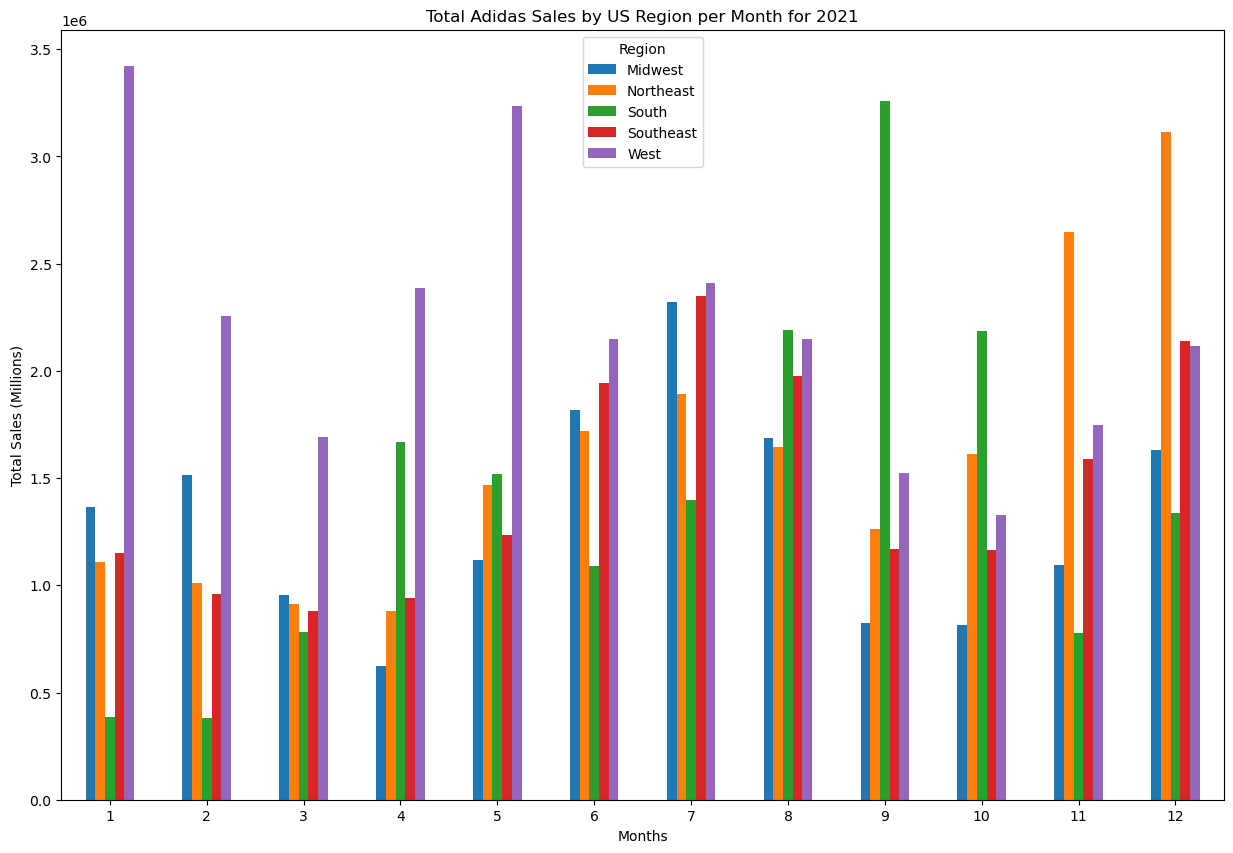

In [94]:
#plotting Total Adidas Sales by US Region per Month for 2021
adidas_2021_monthly_sales_by_region = adidas_2021_monthly_sales_by_region.groupby(['Region', 'Month'])['Total Sales'].sum().reset_index()

adidas_2021_monthly_sales_by_region.pivot(index='Month', columns='Region', values='Total Sales').plot(kind='bar', figsize=(15, 10))

plt.title('Total Adidas Sales by US Region per Month for 2021')
plt.xlabel('Months')
plt.ylabel('Total Sales (Millions)')
plt.xticks(rotation=0)
plt.show()

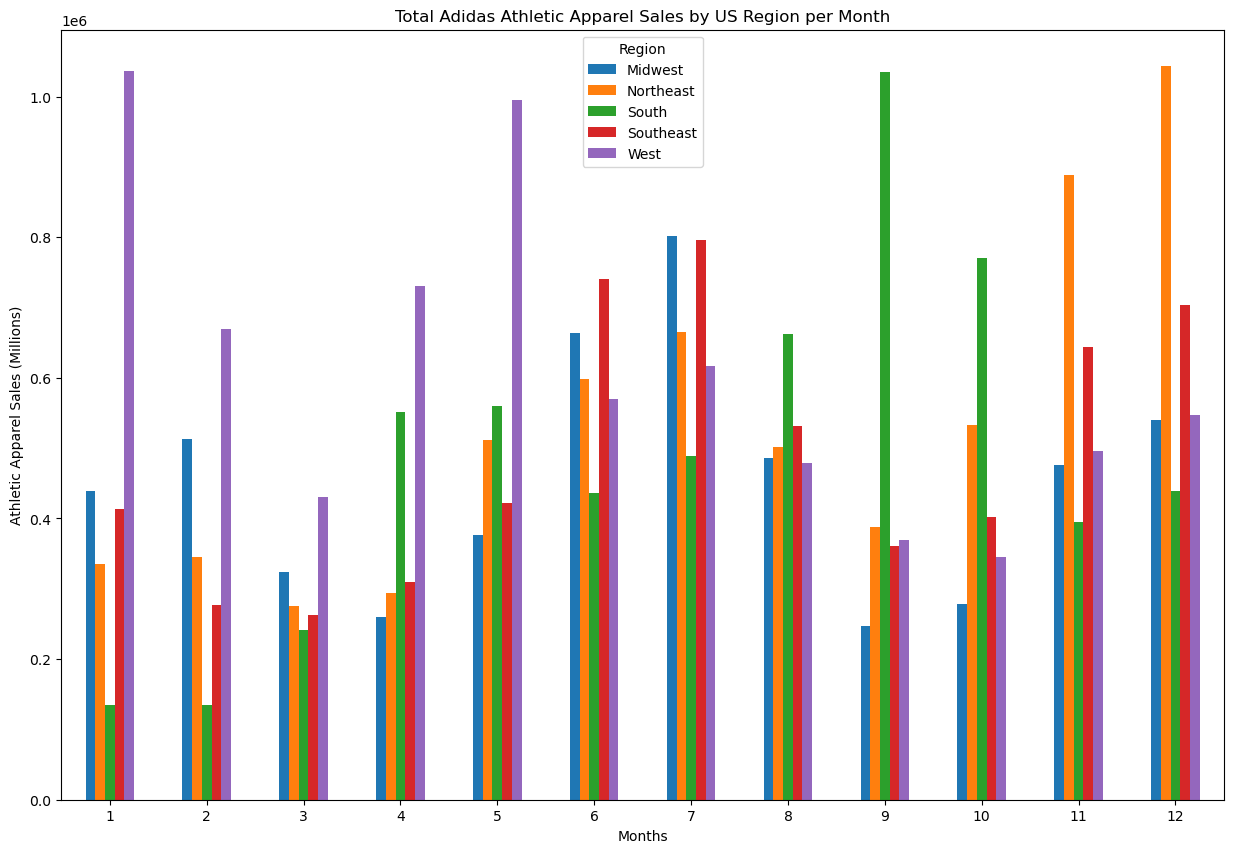

In [95]:
#plotting Total Adidas Athletic Footwear Sales by US Region per Month
adidas_apparel_by_month = adidas_apparel_by_month.groupby(['Region', 'Month'])['Total Sales'].sum().reset_index()

adidas_apparel_by_month.pivot(index='Month', columns='Region', values='Total Sales').plot(kind='bar', figsize=(15, 10))

plt.title('Total Adidas Athletic Apparel Sales by US Region per Month')
plt.xlabel('Months')
plt.ylabel('Athletic Apparel Sales (Millions)')
plt.xticks(rotation=0)
plt.show()

In [96]:
mw_month_sales = adidas_apparel_by_month.set_index('Region')
mw_month_sales = mw_month_sales.loc['Midwest']
mw_month_sales = mw_month_sales.reset_index()
mw_month_sales.drop('Region', axis=1, inplace=True)
mw_month_sales = mw_month_sales.sort_values('Month')
mw_month_sales = mw_month_sales.set_index('Month')
mw_month_sales.head()

,Total Sales
Month,
1,439536.0
2,512593.0
3,323676.0
4,259975.0
5,375796.0


In [97]:
ne_month_sales = adidas_apparel_by_month.set_index('Region')
ne_month_sales = ne_month_sales.loc['Northeast']
ne_month_sales = ne_month_sales.reset_index()
ne_month_sales.drop('Region', axis=1, inplace=True)
ne_month_sales = ne_month_sales.sort_values('Month')
ne_month_sales = ne_month_sales.set_index('Month')
ne_month_sales.head()

,Total Sales
Month,
1,334596.0
2,345500.0
3,276122.0
4,293911.0
5,511912.0


In [98]:
w_month_sales = adidas_apparel_by_month.set_index('Region')
w_month_sales = w_month_sales.loc['West']
w_month_sales = w_month_sales.reset_index()
w_month_sales.drop('Region', axis=1, inplace=True)
w_month_sales = w_month_sales.sort_values('Month')
w_month_sales = w_month_sales.set_index('Month')
w_month_sales.head()

,Total Sales
Month,
1,1035827.0
2,670007.0
3,430574.0
4,730768.0
5,994770.0


In [99]:
se_month_sales = adidas_apparel_by_month.set_index('Region')
se_month_sales = se_month_sales.loc['Southeast']
se_month_sales = se_month_sales.reset_index()
se_month_sales.drop('Region', axis=1, inplace=True)
se_month_sales = se_month_sales.sort_values('Month')
se_month_sales = se_month_sales.set_index('Month')
se_month_sales.head()

,Total Sales
Month,
1,413804.0
2,277001.0
3,262051.0
4,309471.0
5,421722.0


In [100]:
s_month_sales = adidas_apparel_by_month.set_index('Region')
s_month_sales = s_month_sales.loc['South']
s_month_sales = s_month_sales.reset_index()
s_month_sales.drop('Region', axis=1, inplace=True)
s_month_sales = s_month_sales.sort_values('Month')
s_month_sales = s_month_sales.set_index('Month')
s_month_sales.head()

,Total Sales
Month,
1,134380.0
2,135019.0
3,241261.0
4,551224.0
5,560584.0


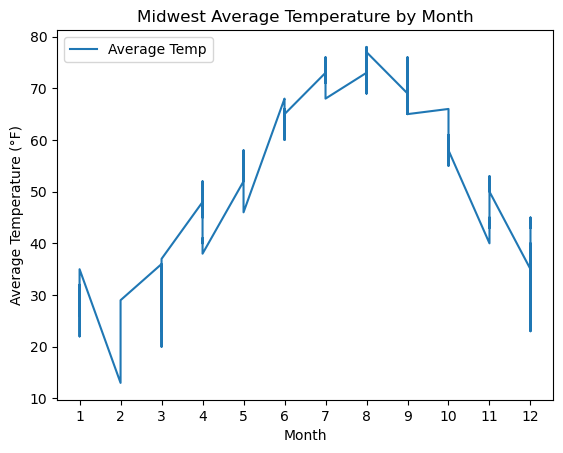

In [101]:
mw_region_month_temp.plot()
plt.title('Midwest Average Temperature by Month')
plt.ylabel('Average Temperature (°F)')
plt.xticks(range(1,13))
plt.show()

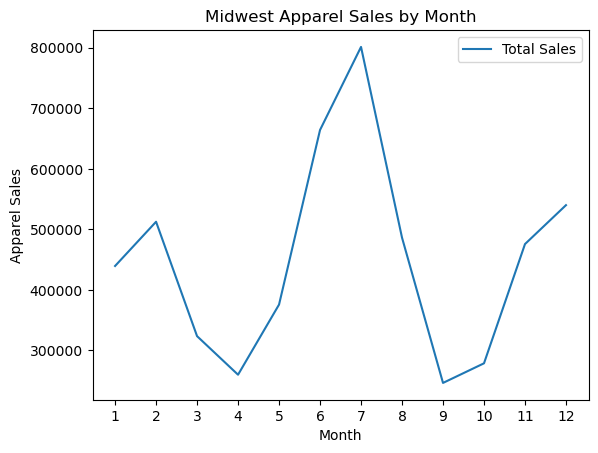

In [102]:
mw_month_sales.plot()
plt.title('Midwest Apparel Sales by Month')
plt.ylabel('Apparel Sales')
plt.xticks(range(1,13))
plt.show()

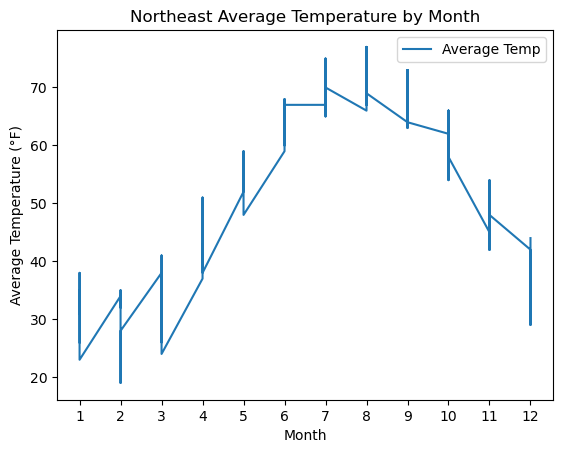

In [103]:
ne_region_month_temp.plot()
plt.title('Northeast Average Temperature by Month')
plt.ylabel('Average Temperature (°F)')
plt.xticks(range(1,13))
plt.show()

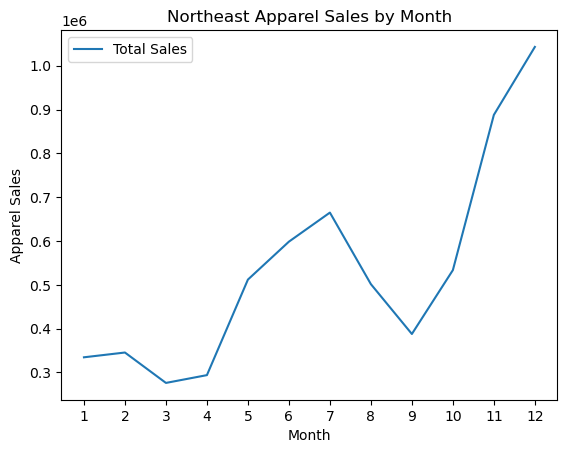

In [104]:
ne_month_sales.plot()
plt.title('Northeast Apparel Sales by Month')
plt.ylabel('Apparel Sales')
plt.xticks(range(1,13))
plt.show()

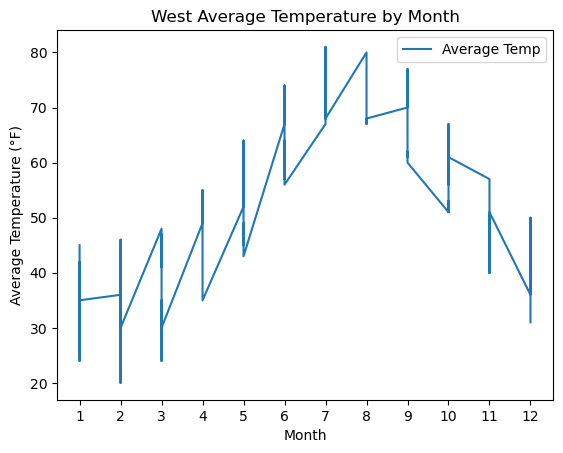

In [105]:
w_region_month_temp.plot()
plt.title('West Average Temperature by Month')
plt.ylabel('Average Temperature (°F)')
plt.xticks(range(1,13))
plt.show()

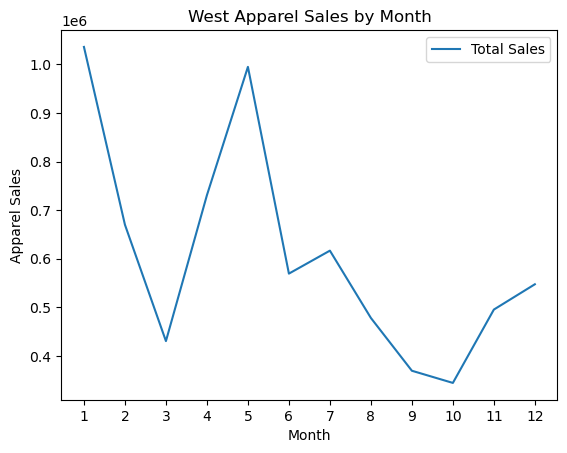

In [106]:
w_month_sales.plot()
plt.title('West Apparel Sales by Month')
plt.ylabel('Apparel Sales')
plt.xticks(range(1,13))
plt.show()

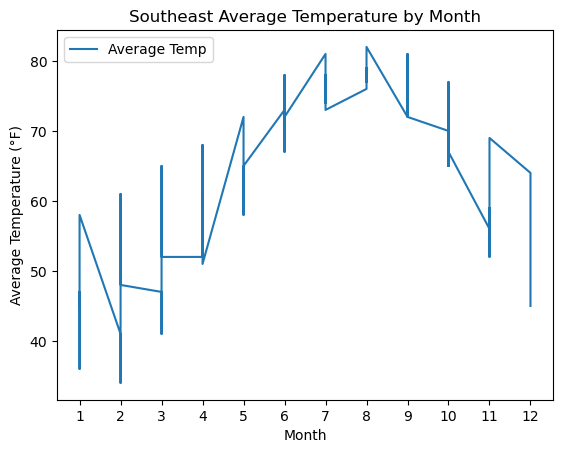

In [107]:
se_region_month_temp.plot()
plt.title('Southeast Average Temperature by Month')
plt.ylabel('Average Temperature (°F)')
plt.xticks(range(1,13))
plt.show()

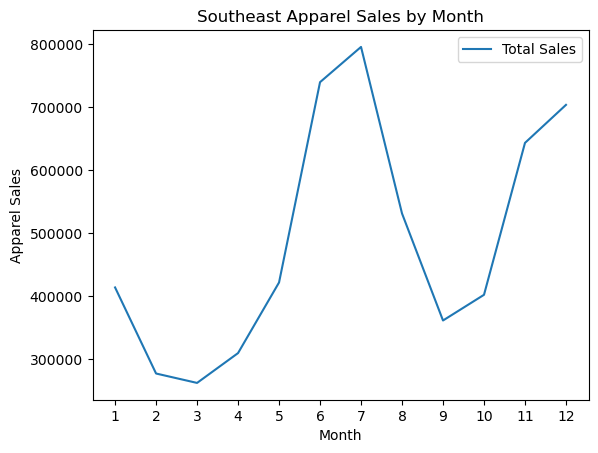

In [108]:
se_month_sales.plot()
plt.title('Southeast Apparel Sales by Month')
plt.ylabel('Apparel Sales')
plt.xticks(range(1,13))
plt.show()

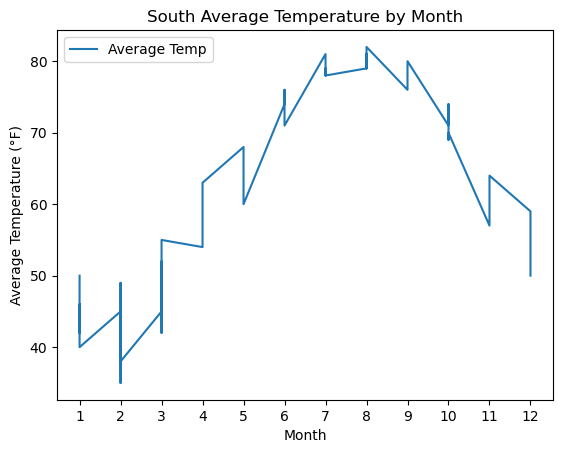

In [109]:
s_region_month_temp.plot()
plt.title('South Average Temperature by Month')
plt.ylabel('Average Temperature (°F)')
plt.xticks(range(1,13))
plt.show()

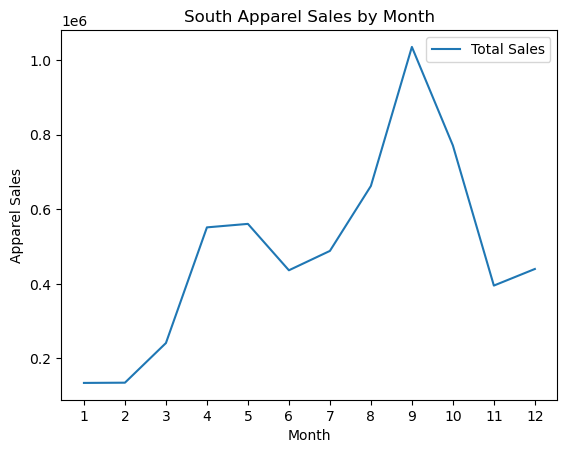

In [110]:
s_month_sales.plot()
plt.title('South Apparel Sales by Month')
plt.ylabel('Apparel Sales')
plt.xticks(range(1,13))
plt.show()

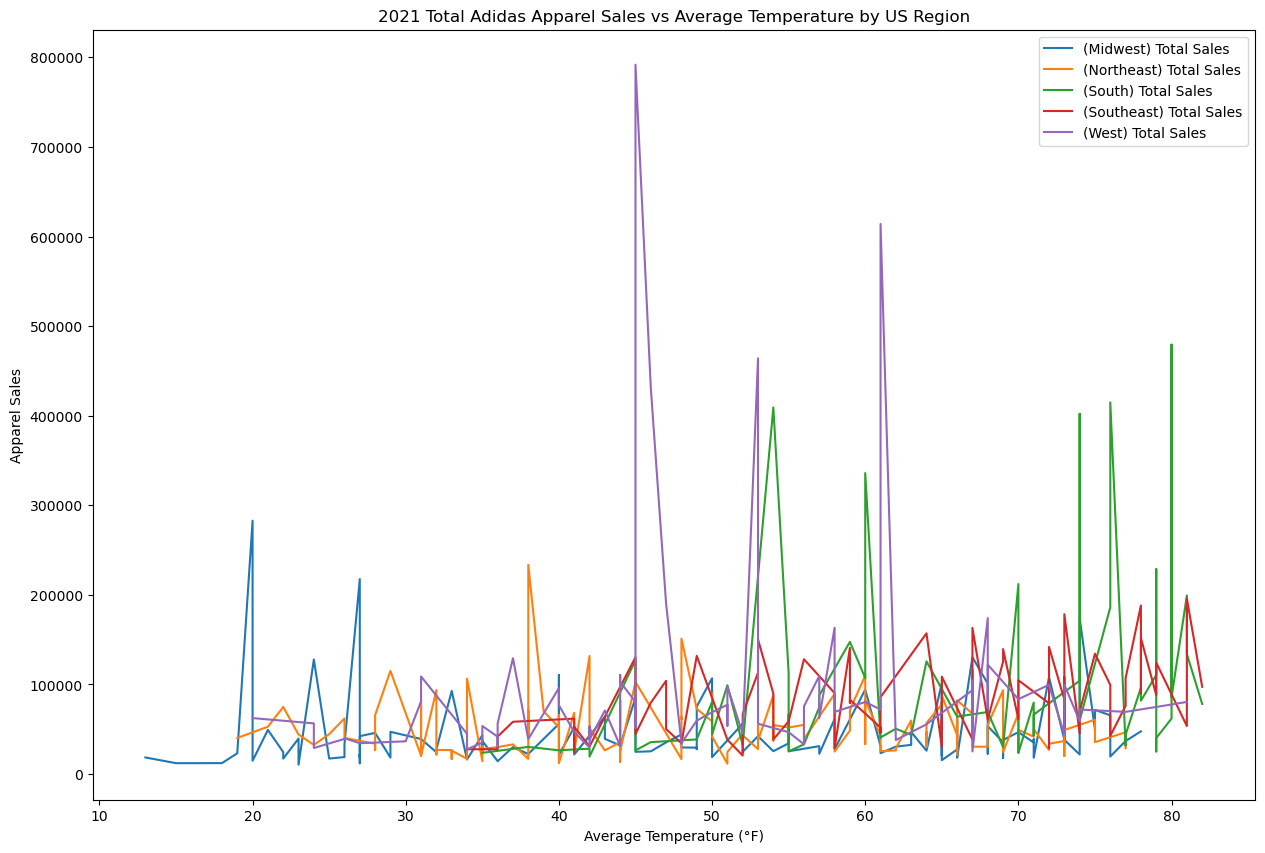

In [111]:
#plotting 2021 Total Adidas Athletic Footwear Sales vs Average Temperature by US Region
fig, ax = plt.subplots(figsize=(15, 10))

adidas_apparel_mw.plot(ax=ax)
adidas_apparel_ne.plot(ax=ax)
adidas_apparel_s.plot(ax=ax)
adidas_apparel_se.plot(ax=ax)
adidas_apparel_w.plot(ax=ax)
plt.title('2021 Total Adidas Apparel Sales vs Average Temperature by US Region')
plt.xlabel('Average Temperature (°F)')
plt.ylabel('Apparel Sales')
plt.show()

In [113]:
#Create a footwear trends df with a Datetime index
adidas_trends = adidas_apparel.reset_index()
adidas_trends.drop('State', axis = 1, inplace=True)

# Merging Year and Month columns as a datetime dtype
adidas_trends['Date'] = pd.to_datetime(adidas_trends['Year'].astype(str) + '-' + adidas_trends['Month'].astype(str).str.zfill(2))


# Setting index to the new datetime 'Date' column
adidas_trends = adidas_trends.set_index('Date')

# Dropping the now irrelevant duplicate columns
adidas_trends.drop(['Year', 'Month'], axis=1, inplace=True)

#adding mens and womens sales for a Total Sales column
adidas_trends['Total Sales'] = adidas_trends['Men\'s Apparel Sales'] + adidas_trends['Women\'s Apparel Sales']

#filtering to only the needed columns
adidas_trends = adidas_trends[['Region', 'Total Sales']]

#sort by Date
adidas_trends = adidas_trends.sort_index()

#slice for only 2021 data
adidas_trends = adidas_trends.loc['2021']
adidas_trends.head()


,Region,Total Sales
Date,,
2021-01-01,Northeast,44457.0
2021-01-01,Midwest,24565.0
2021-01-01,Northeast,21704.0
2021-01-01,South,26478.0
2021-01-01,Midwest,217678.0


In [114]:
#slice for Midwest and prepare data for Prophet Model
adidas_mw_trends = adidas_trends.reset_index()
adidas_mw_trends = adidas_mw_trends[['Region', 'Date', 'Total Sales']]
adidas_mw_trends = adidas_mw_trends.set_index('Region')
adidas_mw_trends = adidas_mw_trends.loc['Midwest']
adidas_mw_trends = adidas_mw_trends.reset_index()
adidas_mw_trends.drop('Region', axis=1, inplace=True)
adidas_mw_trends = adidas_mw_trends.rename(
    columns={
        'Date': 'ds',
        'Total Sales': 'y'
    }
)
adidas_mw_trends.head()

,ds,y
0,2021-01-01,24565.0
1,2021-01-01,217678.0
2,2021-01-01,31546.0
3,2021-01-01,24263.0
4,2021-01-01,17254.0


In [115]:
#repeat for Northeast
adidas_ne_trends = adidas_trends.reset_index()
adidas_ne_trends = adidas_ne_trends[['Region', 'Date', 'Total Sales']]
adidas_ne_trends = adidas_ne_trends.set_index('Region')
adidas_ne_trends = adidas_ne_trends.loc['Northeast']
adidas_ne_trends = adidas_ne_trends.reset_index()
adidas_ne_trends.drop('Region', axis=1, inplace=True)
adidas_ne_trends = adidas_ne_trends.rename(
    columns={
        'Date': 'ds',
        'Total Sales': 'y'
    }
)
adidas_ne_trends.head()

,ds,y
0,2021-01-01,44457.0
1,2021-01-01,21704.0
2,2021-01-01,27937.0
3,2021-01-01,26119.0
4,2021-01-01,40974.0


In [116]:
#repeat for West
adidas_w_trends = adidas_trends.reset_index()
adidas_w_trends = adidas_w_trends[['Region', 'Date', 'Total Sales']]
adidas_w_trends = adidas_w_trends.set_index('Region')
adidas_w_trends = adidas_w_trends.loc['West']
adidas_w_trends = adidas_w_trends.reset_index()
adidas_w_trends.drop('Region', axis=1, inplace=True)
adidas_w_trends = adidas_w_trends.rename(
    columns={
        'Date': 'ds',
        'Total Sales': 'y'
    }
)
adidas_w_trends.head()

,ds,y
0,2021-01-01,44924.0
1,2021-01-01,39927.0
2,2021-01-01,34361.0
3,2021-01-01,42590.0
4,2021-01-01,791798.0


In [117]:
#repeat for Southeast
adidas_se_trends = adidas_trends.reset_index()
adidas_se_trends = adidas_se_trends[['Region', 'Date', 'Total Sales']]
adidas_se_trends = adidas_se_trends.set_index('Region')
adidas_se_trends = adidas_se_trends.loc['Southeast']
adidas_se_trends = adidas_se_trends.reset_index()
adidas_se_trends.drop('Region', axis=1, inplace=True)
adidas_se_trends = adidas_se_trends.rename(
    columns={
        'Date': 'ds',
        'Total Sales': 'y'
    }
)
adidas_se_trends.head()

,ds,y
0,2021-01-01,90342.0
1,2021-01-01,41702.0
2,2021-01-01,104051.0
3,2021-01-01,58325.0
4,2021-01-01,66716.0


In [118]:
#repeat for South
adidas_s_trends = adidas_trends.reset_index()
adidas_s_trends = adidas_s_trends[['Region', 'Date', 'Total Sales']]
adidas_s_trends = adidas_s_trends.set_index('Region')
adidas_s_trends = adidas_s_trends.loc['South']
adidas_s_trends = adidas_s_trends.reset_index()
adidas_s_trends.drop('Region', axis=1, inplace=True)
adidas_s_trends = adidas_s_trends.rename(
    columns={
        'Date': 'ds',
        'Total Sales': 'y'
    }
)
adidas_s_trends.head()

,ds,y
0,2021-01-01,26478.0
1,2021-01-01,35578.0
2,2021-01-01,44036.0
3,2021-01-01,28288.0
4,2021-02-01,42448.0


In [119]:
'''Call, fit, and create future and forecast dataframes with Prophet\n
For Midwest, Northeast, West, Southeast, South, and Total 2021 datasets'''

mw_model = Prophet()
mw_model

In [120]:
ne_model = Prophet()
ne_model

In [121]:
w_model = Prophet()
w_model

In [122]:
se_model = Prophet()
se_model

In [123]:
s_model = Prophet()
s_model

In [124]:
mw_model.fit(adidas_mw_trends)

22:47:06 - cmdstanpy - INFO - Chain [1] start processing


22:47:06 - cmdstanpy - INFO - Chain [1] done processing


In [125]:
ne_model.fit(adidas_ne_trends)

22:47:09 - cmdstanpy - INFO - Chain [1] start processing
22:47:09 - cmdstanpy - INFO - Chain [1] done processing


In [126]:
w_model.fit(adidas_w_trends)

22:47:12 - cmdstanpy - INFO - Chain [1] start processing
22:47:12 - cmdstanpy - INFO - Chain [1] done processing


In [127]:
se_model.fit(adidas_se_trends)

22:47:14 - cmdstanpy - INFO - Chain [1] start processing
22:47:14 - cmdstanpy - INFO - Chain [1] done processing


In [128]:
s_model.fit(adidas_s_trends)

22:47:16 - cmdstanpy - INFO - Chain [1] start processing
22:47:16 - cmdstanpy - INFO - Chain [1] done processing


In [129]:
future_mw_trends = mw_model.make_future_dataframe(periods=9503, freq='h')

display(future_mw_trends.tail())

,ds
9510,2022-12-31 19:00:00
9511,2022-12-31 20:00:00
9512,2022-12-31 21:00:00
9513,2022-12-31 22:00:00
9514,2022-12-31 23:00:00


In [130]:
future_ne_trends = ne_model.make_future_dataframe(periods=9503, freq='h')
future_ne_trends.tail()

,ds
9510,2022-12-31 19:00:00
9511,2022-12-31 20:00:00
9512,2022-12-31 21:00:00
9513,2022-12-31 22:00:00
9514,2022-12-31 23:00:00


In [131]:
future_w_trends = w_model.make_future_dataframe(periods=9503, freq='h')
future_w_trends.tail()

,ds
9510,2022-12-31 19:00:00
9511,2022-12-31 20:00:00
9512,2022-12-31 21:00:00
9513,2022-12-31 22:00:00
9514,2022-12-31 23:00:00


In [132]:
future_se_trends = se_model.make_future_dataframe(periods=9503, freq='h')
future_se_trends.tail()

,ds
9510,2022-12-31 19:00:00
9511,2022-12-31 20:00:00
9512,2022-12-31 21:00:00
9513,2022-12-31 22:00:00
9514,2022-12-31 23:00:00


In [133]:
future_s_trends = s_model.make_future_dataframe(periods=9503, freq='h')
future_s_trends.tail()

,ds
9510,2022-12-31 19:00:00
9511,2022-12-31 20:00:00
9512,2022-12-31 21:00:00
9513,2022-12-31 22:00:00
9514,2022-12-31 23:00:00


In [134]:
forecast_mw_trends = mw_model.predict(future_mw_trends)

forecast_mw_trends.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,40597.184507,-3181.948690,94108.195626,40597.184507,40597.184507,0.0,0.0,0.0,0.0,0.0,0.0,40597.184507
1,2021-02-01,41720.396212,-9090.481827,93509.277282,41720.396212,41720.396212,0.0,0.0,0.0,0.0,0.0,0.0,41720.396212
2,2021-03-01,42734.124567,-4460.846780,96447.758294,42734.124567,42734.124567,0.0,0.0,0.0,0.0,0.0,0.0,42734.124567
3,2021-04-01,43856.466699,-4237.208436,93141.260814,43856.466699,43856.466699,0.0,0.0,0.0,0.0,0.0,0.0,43856.466699
4,2021-05-01,44942.604207,-3628.652406,99600.989444,44942.604207,44942.604207,0.0,0.0,0.0,0.0,0.0,0.0,44942.604207


In [135]:
forecast_ne_trends = ne_model.predict(future_ne_trends)
forecast_ne_trends.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,27721.836252,-6531.430052,61415.815628,27721.836252,27721.836252,0.0,0.0,0.0,0.0,0.0,0.0,27721.836252
1,2021-02-01,31828.785276,-3068.937475,68534.096535,31828.785276,31828.785276,0.0,0.0,0.0,0.0,0.0,0.0,31828.785276
2,2021-03-01,35538.287604,-49.719834,73093.634184,35538.287604,35538.287604,0.0,0.0,0.0,0.0,0.0,0.0,35538.287604
3,2021-04-01,39645.236624,4074.309049,73902.067955,39645.236624,39645.236624,0.0,0.0,0.0,0.0,0.0,0.0,39645.236624
4,2021-05-01,43619.703443,10641.036018,78796.686584,43619.703443,43619.703443,0.0,0.0,0.0,0.0,0.0,0.0,43619.703443


In [136]:
forecast_w_trends = w_model.predict(future_w_trends)
forecast_w_trends.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,115494.031674,-40373.457306,268193.179543,115494.031674,115494.031674,0.0,0.0,0.0,0.0,0.0,0.0,115494.031674
1,2021-02-01,111440.633750,-42798.636469,269708.389813,111440.633750,111440.633750,0.0,0.0,0.0,0.0,0.0,0.0,111440.633750
2,2021-03-01,107779.500145,-53478.201089,258552.191785,107779.500145,107779.500145,0.0,0.0,0.0,0.0,0.0,0.0,107779.500145
3,2021-04-01,103726.102224,-44059.904630,258588.883269,103726.102224,103726.102224,0.0,0.0,0.0,0.0,0.0,0.0,103726.102224
4,2021-05-01,99803.459062,-57784.918924,254529.486840,99803.459062,99803.459062,0.0,0.0,0.0,0.0,0.0,0.0,99803.459062


In [137]:
forecast_se_trends = se_model.predict(future_se_trends)
forecast_se_trends.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,55331.785980,4031.404115,110066.863280,55331.785980,55331.785980,0.0,0.0,0.0,0.0,0.0,0.0,55331.785980
1,2021-02-01,60227.477632,5856.710997,113616.018459,60227.477632,60227.477632,0.0,0.0,0.0,0.0,0.0,0.0,60227.477632
2,2021-03-01,64649.392696,15267.840781,115399.767118,64649.392696,64649.392696,0.0,0.0,0.0,0.0,0.0,0.0,64649.392696
3,2021-04-01,69545.084359,20913.902000,120875.145783,69545.084359,69545.084359,0.0,0.0,0.0,0.0,0.0,0.0,69545.084359
4,2021-05-01,74282.850518,20414.639525,124487.960541,74282.850518,74282.850518,0.0,0.0,0.0,0.0,0.0,0.0,74282.850518


In [138]:
forecast_s_trends = s_model.predict(future_s_trends)
forecast_s_trends.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,55698.232422,-79842.699252,187955.824777,55698.232422,55698.232422,0.0,0.0,0.0,0.0,0.0,0.0,55698.232422
1,2021-02-01,64230.241760,-66520.782657,207371.727782,64230.241760,64230.241760,0.0,0.0,0.0,0.0,0.0,0.0,64230.241760
2,2021-03-01,71936.572767,-59447.232428,203573.116605,71936.572767,71936.572767,0.0,0.0,0.0,0.0,0.0,0.0,71936.572767
3,2021-04-01,80468.582106,-52653.333410,221751.691838,80468.582106,80468.582106,0.0,0.0,0.0,0.0,0.0,0.0,80468.582106
4,2021-05-01,88725.364445,-34403.328490,218390.467744,88725.364445,88725.364445,0.0,0.0,0.0,0.0,0.0,0.0,88725.364445


In [140]:
display(adidas_apparel_by_month.head())


,Region,Month,Total Sales
0,Midwest,1,439536.0
1,Midwest,2,512593.0
2,Midwest,3,323676.0
3,Midwest,4,259975.0
4,Midwest,5,375796.0


In [141]:
# Repeating above for Total Apparelsales for 2021
adidas_apparel_by_month['Region'] = 2021

adidas_apparel_by_month.head()

,Region,Month,Total Sales
0,2021,1,439536.0
1,2021,2,512593.0
2,2021,3,323676.0
3,2021,4,259975.0
4,2021,5,375796.0


In [143]:
adidas_apparel_by_month['Date'] = pd.to_datetime(adidas_apparel_by_month['Region'].astype(str) + '-' + adidas_apparel_by_month['Month'].astype(str).str.zfill(2))

adidas_apparel_by_month = adidas_apparel_by_month.set_index('Date')


adidas_apparel_by_month.drop(['Region', 'Month'], axis=1, inplace=True)

adidas_apparel_by_month.head()

,Total Sales
Date,
2021-01-01,439536.0
2021-02-01,512593.0
2021-03-01,323676.0
2021-04-01,259975.0
2021-05-01,375796.0


In [144]:
adidas_apparel_by_month = adidas_apparel_by_month.reset_index()
adidas_apparel_by_month = adidas_apparel_by_month.rename(
    columns={
        'Date': 'ds',
        'Total Sales': 'y'
    }
)
adidas_apparel_by_month.head()

,ds,y
0,2021-01-01,439536.0
1,2021-02-01,512593.0
2,2021-03-01,323676.0
3,2021-04-01,259975.0
4,2021-05-01,375796.0


In [145]:
total_af_model = Prophet()
total_af_model

In [147]:
total_af_model.fit(adidas_apparel_by_month)

22:49:19 - cmdstanpy - INFO - Chain [1] start processing
22:49:19 - cmdstanpy - INFO - Chain [1] done processing


In [148]:
future_total_af_trends = total_af_model.make_future_dataframe(periods=9503, freq='h')
future_total_af_trends.tail()

,ds
9510,2022-12-31 19:00:00
9511,2022-12-31 20:00:00
9512,2022-12-31 21:00:00
9513,2022-12-31 22:00:00
9514,2022-12-31 23:00:00


In [149]:
forecast_total_af_sales = total_af_model.predict(future_total_af_trends)
forecast_total_af_sales.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,416313.134048,146730.018058,691072.936734,416313.134048,416313.134048,0.0,0.0,0.0,0.0,0.0,0.0,416313.134048
1,2021-02-01,434309.067284,163457.011911,694459.732115,434309.067284,434309.067284,0.0,0.0,0.0,0.0,0.0,0.0,434309.067284
2,2021-03-01,450563.458551,181421.343737,717151.097232,450563.458551,450563.458551,0.0,0.0,0.0,0.0,0.0,0.0,450563.458551
3,2021-04-01,468559.391747,207181.183857,727687.677944,468559.391747,468559.391747,0.0,0.0,0.0,0.0,0.0,0.0,468559.391747
4,2021-05-01,485974.811017,231324.627006,741699.523204,485974.811017,485974.811017,0.0,0.0,0.0,0.0,0.0,0.0,485974.811017


In [150]:
# Repeating above for Adidas Total Product sales for 2021
adidas_2021_sales = adidas_2021_sales.reset_index()
adidas_2021_sales['Year'] = 2021

adidas_2021_sales['Date'] = pd.to_datetime(adidas_2021_sales['Year'].astype(str) + '-' + adidas_2021_sales['Month'].astype(str).str.zfill(2))

adidas_2021_sales.drop(['Year', 'Month'], axis=1, inplace=True)

adidas_2021_sales = adidas_2021_sales.rename(
    columns={
        'Date': 'ds',
        '2021 Total Sales per Month': 'y'
    }
)
adidas_2021_sales = adidas_2021_sales[['ds', 'y']]

adidas_2021_sales.head()

,ds,y
0,2021-01-01,7432010
1,2021-02-01,6123021
2,2021-03-01,5220756
3,2021-04-01,6498318
4,2021-05-01,8576901


In [151]:
total_model = Prophet()
total_model

In [152]:
total_model.fit(adidas_2021_sales)

22:49:47 - cmdstanpy - INFO - Chain [1] start processing
22:49:47 - cmdstanpy - INFO - Chain [1] done processing


In [153]:
future_total_trends = total_model.make_future_dataframe(periods=9503, freq='h')
future_total_trends.tail()

,ds
9510,2022-12-31 19:00:00
9511,2022-12-31 20:00:00
9512,2022-12-31 21:00:00
9513,2022-12-31 22:00:00
9514,2022-12-31 23:00:00


In [154]:
forecast_total_sales = total_model.predict(future_total_trends)
forecast_total_sales.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,6.593544e+06,4.895673e+06,8.256299e+06,6.593544e+06,6.593544e+06,0.0,0.0,0.0,0.0,0.0,0.0,6.593544e+06
1,2021-02-01,6.854452e+06,5.119449e+06,8.433302e+06,6.854452e+06,6.854452e+06,0.0,0.0,0.0,0.0,0.0,0.0,6.854452e+06
2,2021-03-01,7.090111e+06,5.420644e+06,8.742880e+06,7.090111e+06,7.090111e+06,0.0,0.0,0.0,0.0,0.0,0.0,7.090111e+06
3,2021-04-01,7.351020e+06,5.547559e+06,8.971249e+06,7.351020e+06,7.351020e+06,0.0,0.0,0.0,0.0,0.0,0.0,7.351020e+06
4,2021-05-01,7.603512e+06,5.909794e+06,9.280637e+06,7.603512e+06,7.603512e+06,0.0,0.0,0.0,0.0,0.0,0.0,7.603512e+06


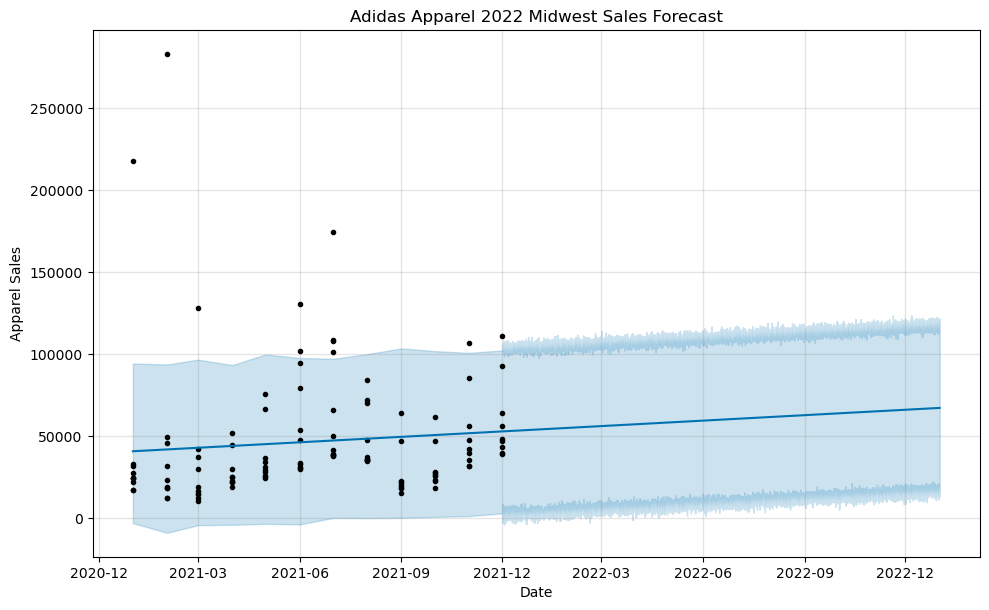

In [155]:
'''Plotting Trend Forecast Predictions for Each Region and Combined Regional Trend Forecast Predictions'''
mw_model.plot(forecast_mw_trends)
plt.title('Adidas Apparel 2022 Midwest Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Apparel Sales')
plt.show()

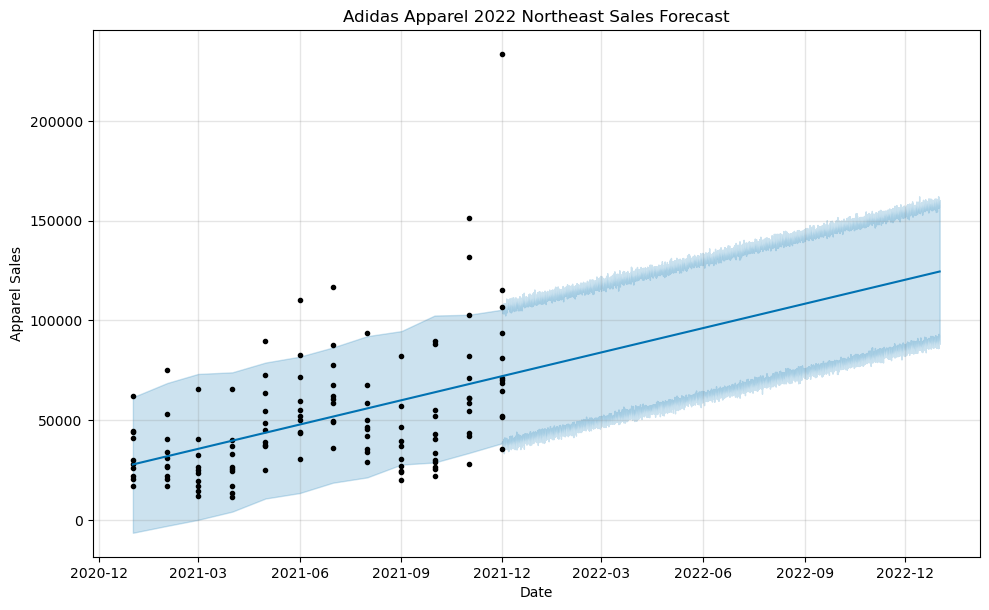

In [156]:
ne_model.plot(forecast_ne_trends)
plt.title('Adidas Apparel 2022 Northeast Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Apparel Sales')
plt.show()

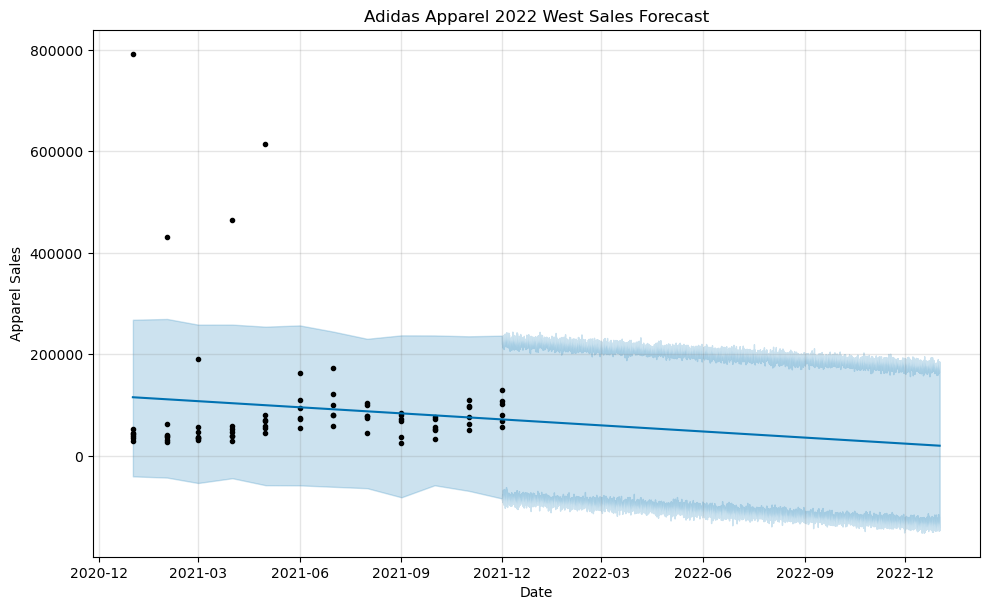

In [157]:
w_model.plot(forecast_w_trends)
plt.title('Adidas Apparel 2022 West Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Apparel Sales')
plt.show()

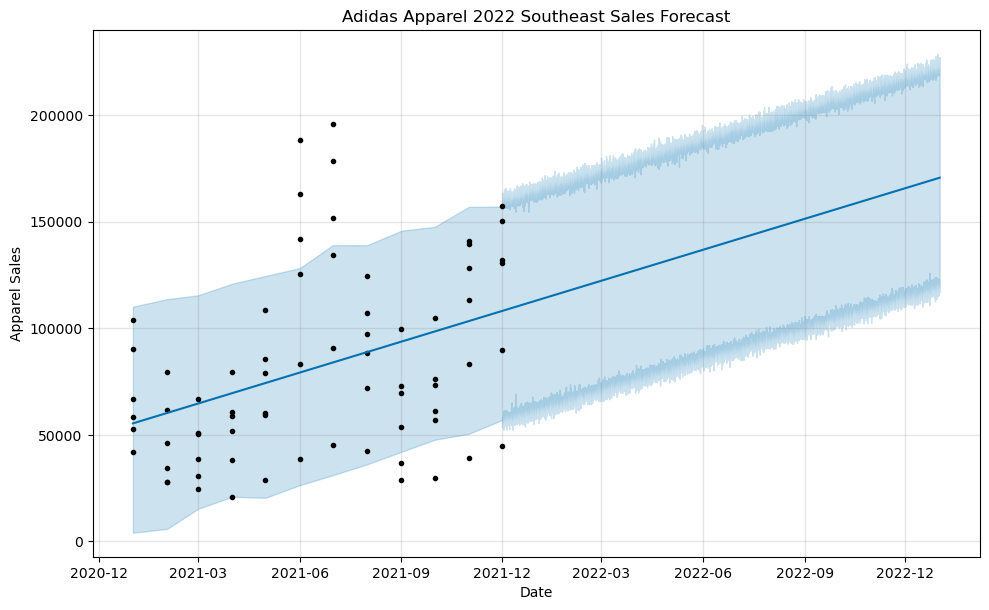

In [158]:
se_model.plot(forecast_se_trends)
plt.title('Adidas Apparel 2022 Southeast Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Apparel Sales')
plt.show()

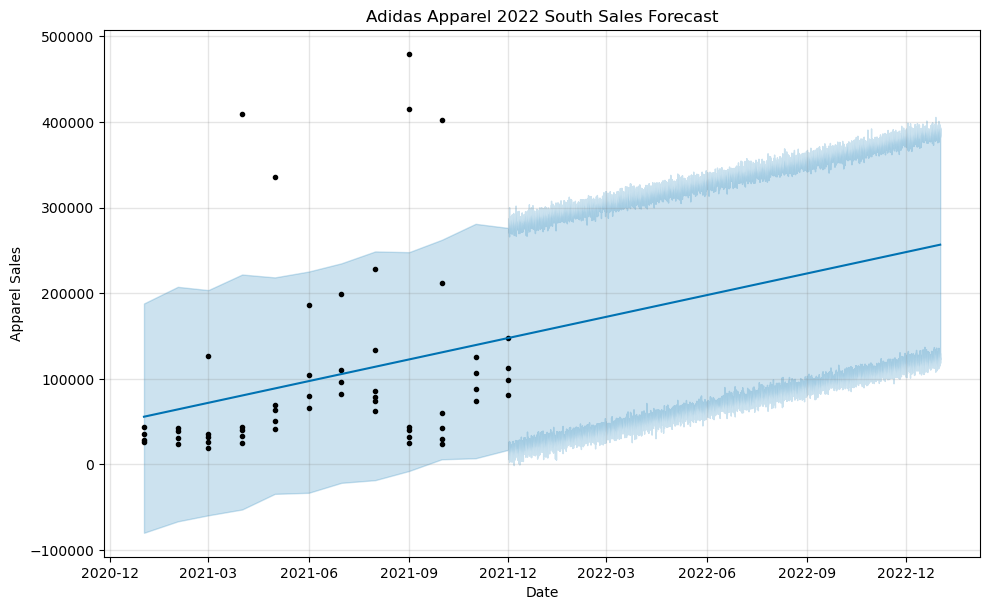

In [159]:
s_model.plot(forecast_s_trends)
plt.title('Adidas Apparel 2022 South Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Apparel Sales')
plt.show()

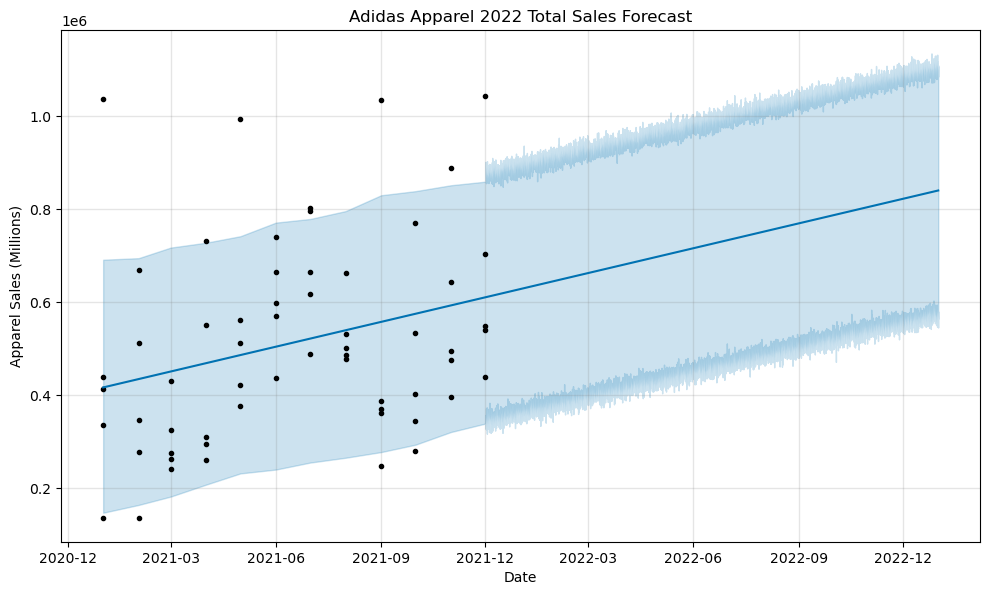

In [160]:
total_af_model.plot(forecast_total_af_sales)
plt.title('Adidas Apparel 2022 Total Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Apparel Sales (Millions)')
plt.show()

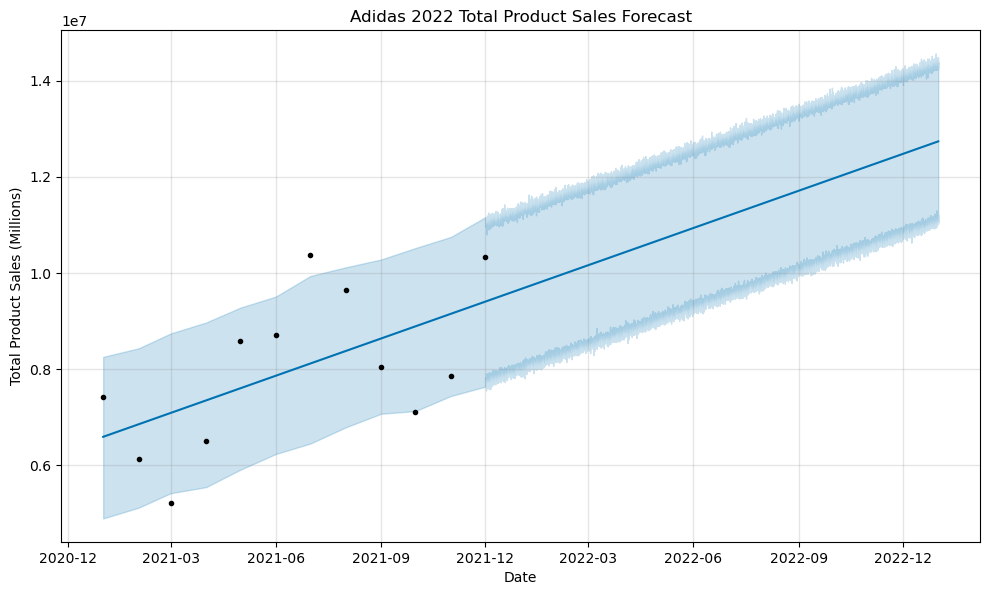

In [161]:
total_model.plot(forecast_total_sales)
plt.title('Adidas 2022 Total Product Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Total Product Sales (Millions)')
plt.show()

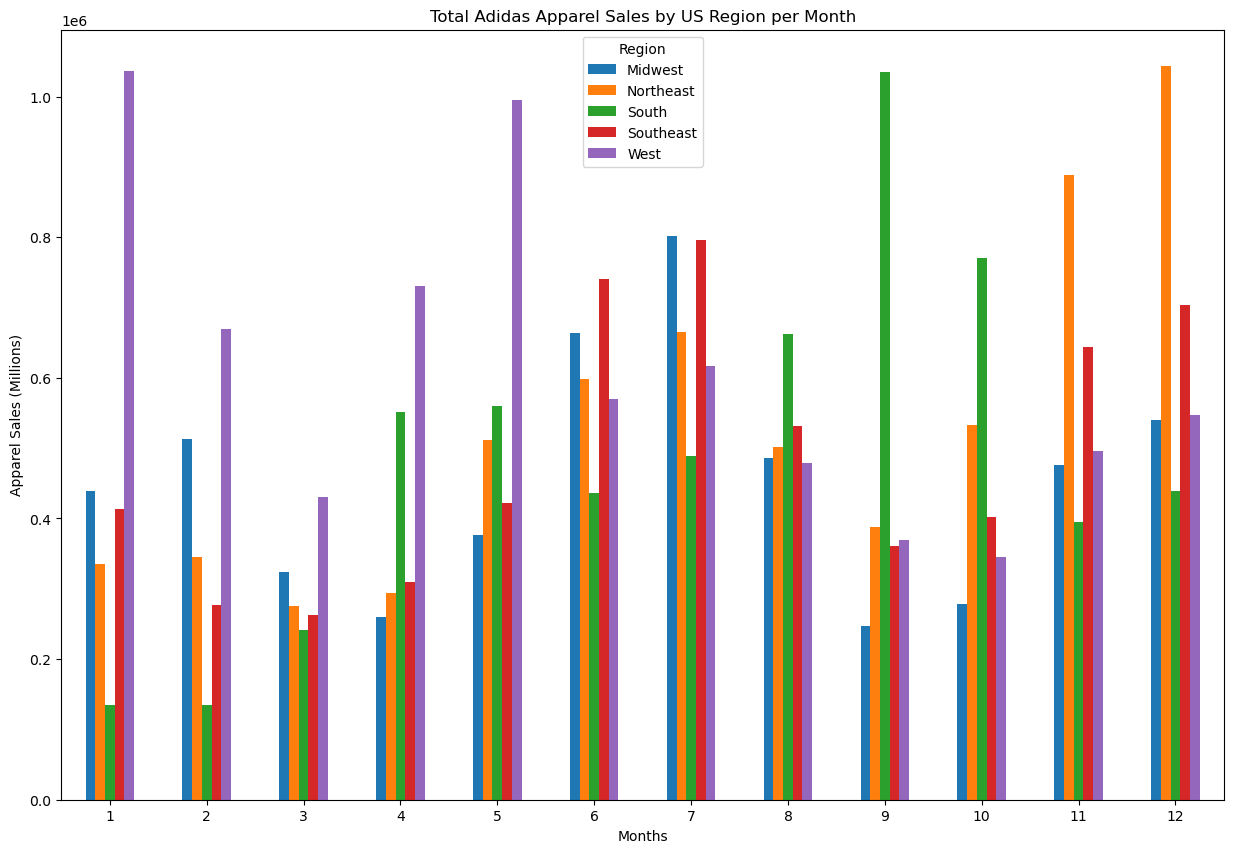

In [186]:
adidas_apparel_by_month = 'Resources/apparel_csvs/adidas_apparel_by_month'
adidas_apparel_by_month = pd.read_csv(adidas_apparel_by_month)


adidas_apparel_by_month = adidas_apparel_by_month
adidas_apparel_by_month = adidas_apparel_by_month.groupby(['Region', 'Month'])["Total Sales"].sum().reset_index()
adidas_apparel_by_month.pivot(index='Month', columns='Region', values='Total Sales').plot(kind='bar', figsize=(15, 10))


plt.title('Total Adidas Apparel Sales by US Region per Month')
plt.xlabel('Months')
plt.ylabel('Apparel Sales (Millions)')
plt.xticks(rotation=0)
plt.show()

In [ ]:
#make sure to complete all thegraphs, add in prophet for predictions on all and do correlation by region

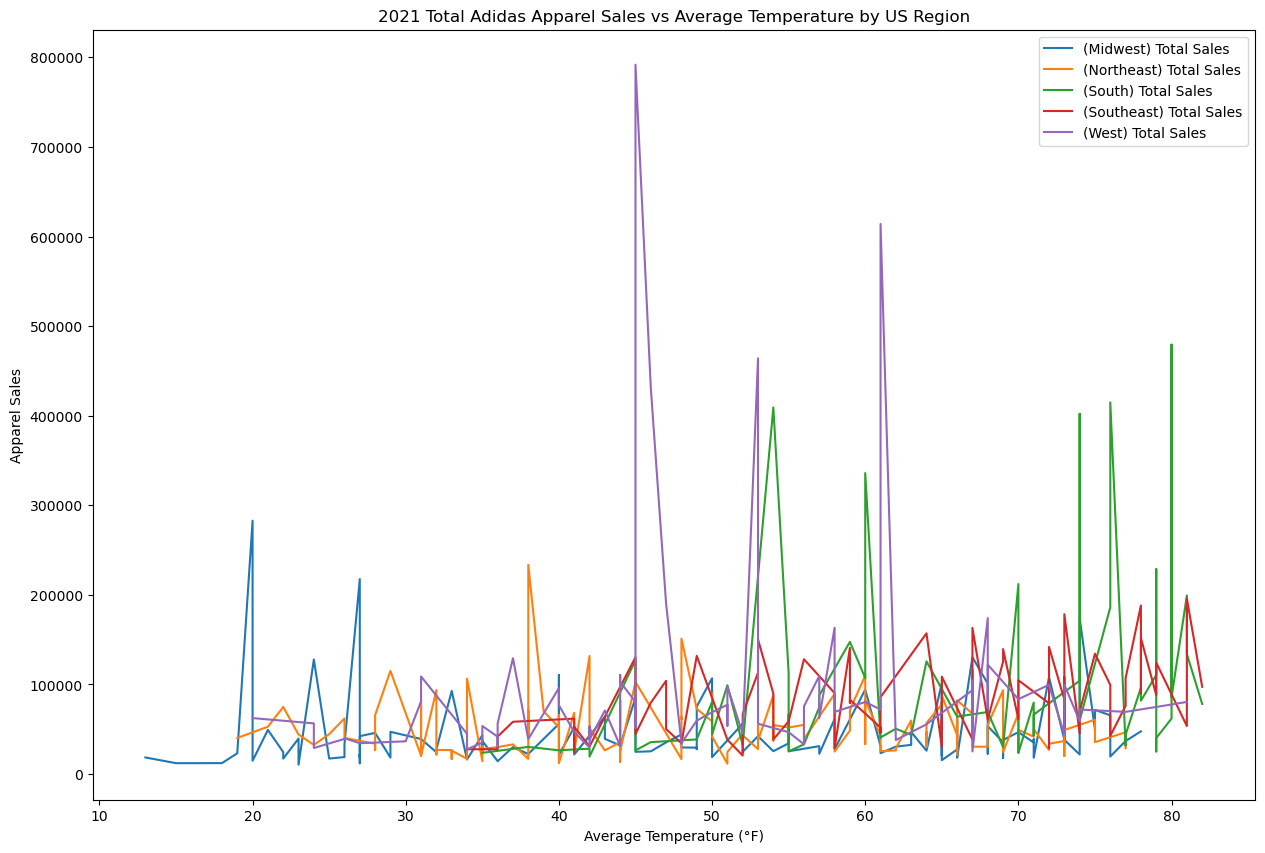

In [163]:
#plotting 2021 Total Adidas Apparel Sales vs Average Temperature by US Region
fig, ax = plt.subplots(figsize=(15, 10))

adidas_apparel_mw.plot(ax=ax)
adidas_apparel_ne.plot(ax=ax)
adidas_apparel_s.plot(ax=ax)
adidas_apparel_se.plot(ax=ax)
adidas_apparel_w.plot(ax=ax)
plt.title('2021 Total Adidas Apparel Sales vs Average Temperature by US Region')
plt.xlabel('Average Temperature (°F)')
plt.ylabel('Apparel Sales')
plt.show()

In [ ]:
NEED TO FIX relative loc
NE_apparel_sales = "Resources/....ne_apparel_temp
NE_apparel_sales = pd.read_csv(NE_apparel_sales)

NE_apparel_sales = NE_apparel_sales.set_index('Average Temp')
NE_apparel_sales.plot
plt.title('North East Apparel Sales by Average Temperature')
plt.ylabel('Apparel Sales')
plt.xlabel('Average Temperature')
plt.legend('Apparel Footwear Sales')

plt.show()

Text(0.5, 1.0, '2021 Share of Sales by Region')

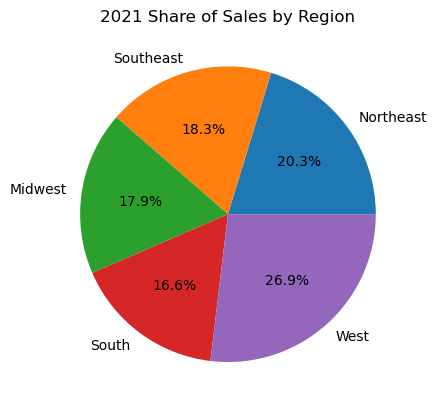

In [294]:
data = {'Region': ['Northeast', 'Southeast', 'Midwest', 'South', 'West'], 'Sales': [145574358, 131570373, 128422391, 119206299, 193048029]}
df = pd.DataFrame(data)
plt.pie(df['Sales'], labels=df['Region'], autopct='%1.1f%%')
plt.title('2021 Share of Sales by Region')


Text(0.5, 1.0, '2021 Share of Sales by Category')

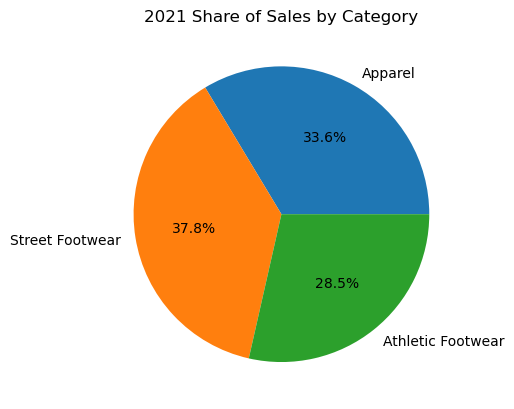

In [296]:
data = {'Product': ['Apparel', 'Street Footwear', 'Athletic Footwear'], 'Sales': [241360196, 271580032, 204881222]}
df = pd.DataFrame(data)
plt.pie(df['Sales'], labels=df['Product'], autopct='%1.1f%%')
plt.title('2021 Share of Sales by Category')

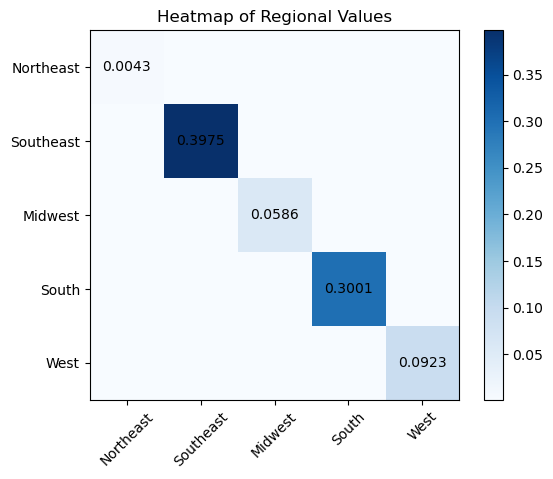

In [165]:
# Creating the heatmap to show correlation values
regions = ["Northeast", "Southeast", "Midwest", "South", "West"]
values = [0.004252, 0.397515, 0.058553, 0.30011, 0.092317]

# make the array
data = [[0] * len(regions) for _ in range(len(regions))]
for i, region in enumerate(regions):
    data[i][i] = values[i]

# make the heatmap
fig, ax = plt.subplots()
im = ax.imshow(data, cmap='Blues', vmin=0.001)  

# Set labels etc
ax.set_xticks(range(len(regions)))
ax.set_yticks(range(len(regions)))
ax.set_xticklabels(regions, rotation=45)
ax.set_yticklabels(regions)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)


for i in range(len(regions)):
    for j in range(len(regions)):
        if data[i][j] > 0.001:
            text = ax.text(j, i, f"{data[i][j]:.4f}",
                           ha="center", va="center", color="black")

# Set title
plt.title("Heatmap of Regional Values")

plt.show()

